In [1]:
%matplotlib  inline
import pandas as pd
import iexfinance as iex
from datetime import datetime
import quandl
import xgboost
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *
import sklearn.preprocessing as prep
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy import poly1d
from scipy.stats import pearsonr
import seaborn as sns
from math import sqrt
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pykalman import KalmanFilter
pd.set_option('display.max_columns', 100)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Function definitions

In [2]:
import scipy.ndimage as ndimage

def customLoss(actual,pred):
    alpha = 100
    t = 0
    if (actual * pred > 0):
        t = abs(actual-pred)
    else:
        t = alpha*pred**2 - np.sign(actual)*pred + abs(actual)
    return (t)
        
def logReturns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, max_distance):
    """Group extremes by cluster based on absolute price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= max_distance:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
    
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

def calc_kalman(dataframe):
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = dataframe.values        
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(array)
    state_means = state_means.flatten()
    state_means = pd.DataFrame(data=state_means,index=dataframe.index)
    state_means.columns = ['KF']
    state_means["KF"][0:9]  = float(np.mean(state_means[9:15]).values)
    return state_means

def calc_extreme_groups (dataframe,find_max=True,mDistance = 20,tolerance=0.02,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,1)
    return extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr

# Data collection from IEX for daily data

In [3]:
quandl.ApiConfig.api_key = "xoemPs9s3Dtwf3aQxQ-3"
start="2010-01-02"

INTC = pdr.get_data_yahoo("INTC",start=start)
MSFT = pdr.get_data_yahoo("MSFT",start=start)
AMZN = pdr.get_data_yahoo("AMZN",start=start)
NVDA = pdr.get_data_yahoo("NVDA",start=start)
GOOG = pdr.get_data_yahoo("GOOG",start=start)
NFLX = pdr.get_data_yahoo("NFLX",start=start)
# macro data 
EUROSTOXX50 = pdr.get_data_yahoo("FEZ",start=start)
SNP500 = pdr.get_data_yahoo("^GSPC",start=start)
CONS_DESCRETE = pdr.get_data_yahoo("XLY",start=start)
SNP_TECH = pdr.get_data_yahoo("XLK",start=start)
NASDAQ_COMP = pdr.get_data_yahoo("^IXIC",start=start)
VIX = pdr.get_data_yahoo("^VIX",start=start)

# FRED & Treasury
yieldr = quandl.get("USTREASURY/REALYIELD", start_date=start, verify=False)
consumer_price_index = quandl.get("FRED/CPIAUCSL", start_date=start, verify=False)
gdpc = quandl.get("FRED/GDPC1", start_date=start, verify=False)
tnote_y10 = quandl.get("FRED/DGS10", start_date=start, verify=False)
financial_stress = quandl.get("FRED/STLFSI", start_date=start, verify=False)
effective_federal_fund_rate = quandl.get("FRED/FEDFUNDS", start_date=start, verify=False)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Get extreme values based on nearest neighbour search and plot horizontal support and resistance lines

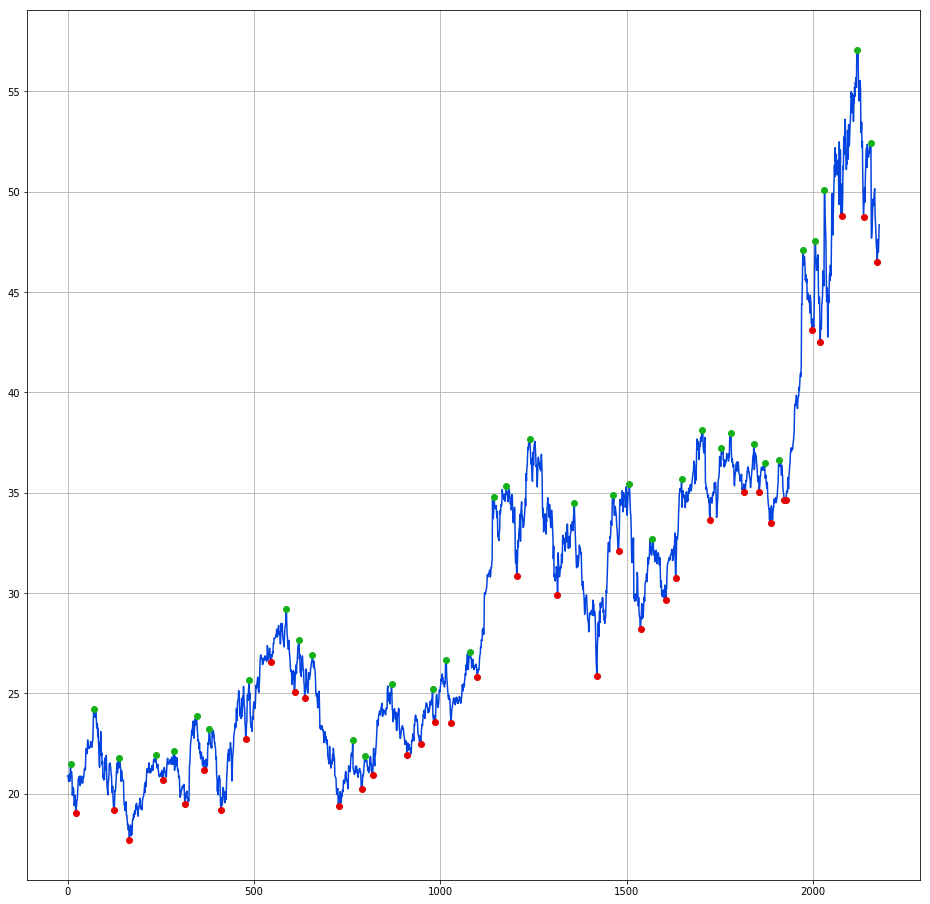

In [4]:
# Plots
cl=np.ravel(INTC[['Close']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 20
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

len of x is: 36


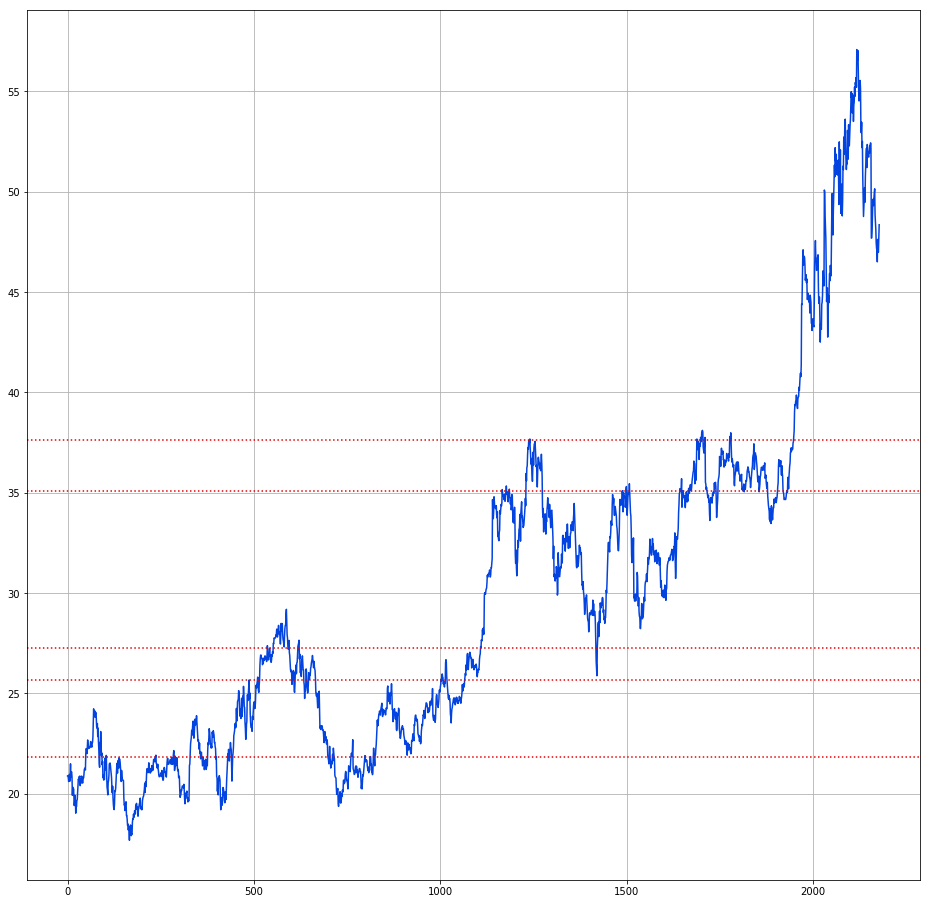

In [5]:
# Show horizontal resistance levels based on extreme points and significance
extremes_res = calc_extreme_groups (INTC[['Close']],signi_level=2,tolerance=0.03)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

len of x is: 37


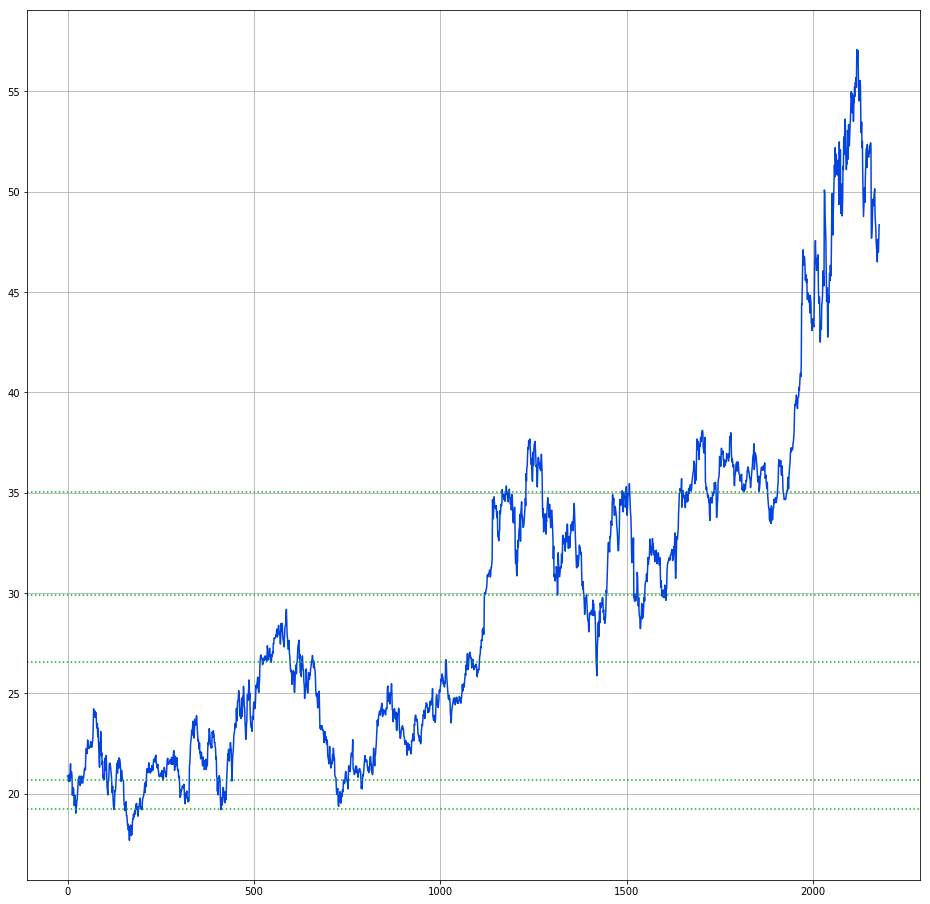

In [6]:
# Show horizontal support levels based on extreme points and significance
extremes_sup = calc_extreme_groups (INTC[['Close']],find_max=False,signi_level=2,tolerance=0.03)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

# Calculate kalman filter estimate of mean

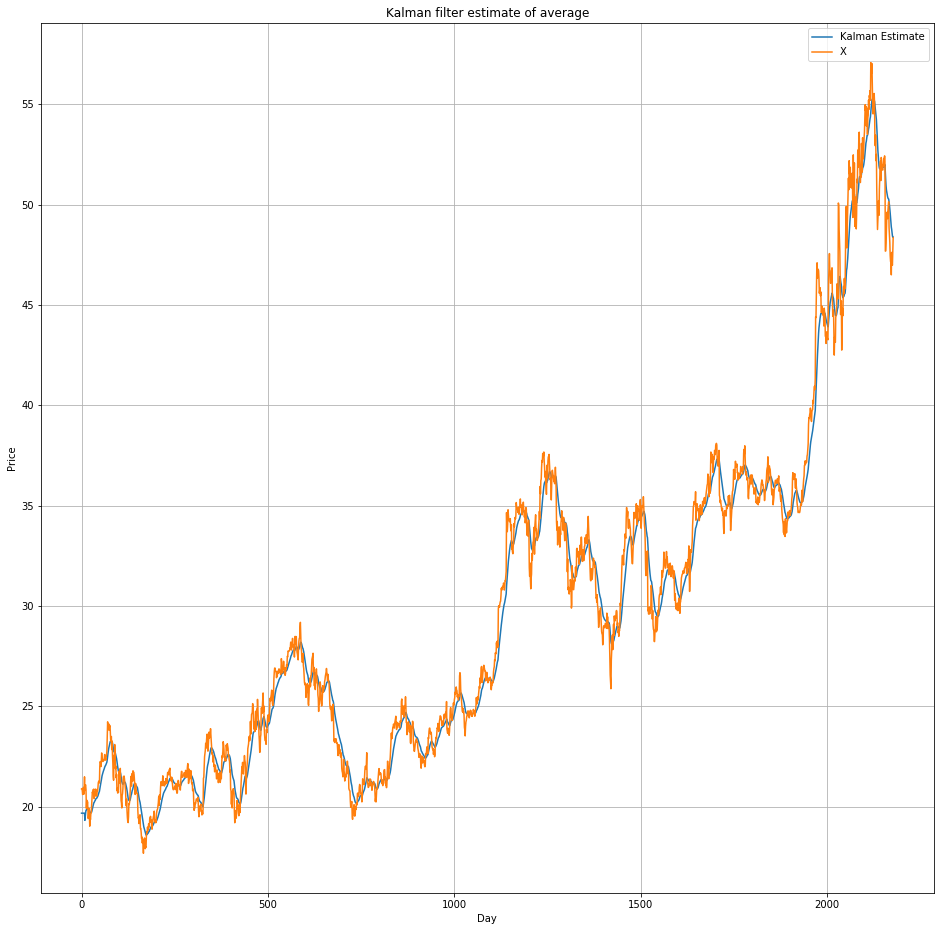

In [10]:
state_means = calc_kalman(INTC['Close'])
plt.rc("figure",figsize=(16,16))
# Plot original data and estimated mean
plt.plot(state_means.values)
plt.plot(cl)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X'])
plt.xlabel('Day')
plt.ylabel('Price');
plt.grid(True)

# Add technical indicators and scale data with MaxAbsScaler or MinMaxScaler

In [11]:
result = pd.concat([INTC, MSFT[['Close']].rename(columns={'Close': 'MSFT'})], axis=1)
result = pd.concat([result, state_means.rename(columns={'KF': 'KF_mean'})], axis=1)
result = pd.concat([result, AMZN[['Close']].rename(columns={'Close': 'AMZN'})], axis=1)
result = pd.concat([result, NVDA[['Close']].rename(columns={'Close': 'NVDA'})], axis=1)
result = pd.concat([result, GOOG[['Close']].rename(columns={'Close': 'GOOG'})], axis=1)
result = pd.concat([result, NFLX[['Close']].rename(columns={'Close': 'NFLX'})], axis=1)
result = pd.concat([result, EUROSTOXX50[['Close']].rename(columns={'Close': 'EUROSTOXX50'})], axis=1)
result = pd.concat([result, SNP500[['Close']].rename(columns={'Close': 'SNP500'})], axis=1)
result = pd.concat([result, CONS_DESCRETE[['Close']].rename(columns={'Close': 'CONS_DESCRETE'})], axis=1)
result = pd.concat([result, SNP_TECH[['Close']].rename(columns={'Close': 'SNP_TECH'})], axis=1)
result = pd.concat([result, NASDAQ_COMP[['Close']].rename(columns={'Close': 'NASDAQ_COMP'})], axis=1)
result = pd.concat([result, VIX[['Close']].rename(columns={'Close': 'VIX'})], axis=1)

# distance to next extremes
sr = calc_next_extreme_distance(INTC[['Close']],extremes_res,extremes_sup)
result = pd.concat([result, sr], axis=1)

# fred
result = pd.concat([result, yieldr[['5 YR']].rename(columns={'5 YR': 'yield_5y'})], axis=1)
result = pd.concat([result, tnote_y10.rename(columns={'Value': 'Tnote_10y'})], axis=1)

result = result.drop('Adj Close', axis=1)
result['Weekday'] = result.index.weekday
result['Weekday'] = result['Weekday'].replace(0,9)
result['Daymonth'] = result.index.day
result['Month'] = result.index.month
result['Weakyear'] = result.index.weekofyear
#result = result.dropna()

In [12]:
result.replace(0, 0.000000001, inplace=True)
result[['yield_5y']] = result[['yield_5y']]+10
logRet = result[['High','Low','Close','MSFT','AMZN','NVDA','GOOG','NFLX','EUROSTOXX50','SNP500',
                 'CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','VIX','yield_5y','Tnote_10y']].apply(logReturns)

logRet.columns = [str(col) + '_logReturns' for col in logRet.columns]

result = pd.concat([result, logRet], axis=1)

In [13]:
momentum  =  result[['Close']].diff(periods=5)
momentum  =  momentum[~np.isnan(momentum)]
result['TradingRange'] = result["High"]-result["Low"]
result['OBV'] = on_balance_volume(result["Close"], result["Volume"])
result['TSI'] = tsi(result["Close"])
result['ATR'] = average_true_range(result["High"],result["Low"],result["Close"])
result['HighestHigh'] = result['High'].rolling(window=21,center=False,min_periods=1).max()
result['LowestLow'] = result['Low'].rolling(window=21,center=False,min_periods=1).min()

result['Volume'].fillna(method ='bfill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['Volume']].values)
result['Volume_Scaled'] = scaler.transform(result[['Volume']].values)

result.head(3)

Open       High    Low      Close      Volume       MSFT  \
Date                                                                        
2010-01-04  20.790001  21.030001  20.73  20.879999  47800900.0  30.950001   
2010-01-05  20.940001  20.990000  20.60  20.870001  52357700.0  30.959999   
2010-01-06  20.809999  20.930000  20.67  20.799999  40037400.0  30.770000   

              KF_mean        AMZN       NVDA        GOOG      NFLX  \
Date                                                                 
2010-01-04  19.668602  133.899994  18.490000  311.349976  7.640000   
2010-01-05  19.668602  134.690002  18.760000  309.978882  7.358572   
2010-01-06  19.668602  132.250000  18.879999  302.164703  7.617143   

            EUROSTOXX50       SNP500  CONS_DESCRETE  SNP_TECH  NASDAQ_COMP  \
Date                                                                         
2010-01-04    42.900002  1132.989990      30.000000     23.27  2308.419922   
2010-01-05    42.700001  1136.520020      30.110001     23.24  2308.709961   
2010-01-06    42.639999  1137.140015      30.150000     22.98  2301.090088   

                  VIX  support_distance  resistance_distance  yield_5y  \
Date                                                                     
2010-01-04  20.040001         10.439999             5.660002     10.52   
2010-01-05  19.350000         10.435001             5.670000     10.44   
2010-01-06  19.160000         10.399999             5.740002     10.44   

            Tnote_10y  Weekday  Daymonth  Month  Weakyear  High_logReturns  \
Date                                                                         
2010-01-04       3.85        9         4      1         1              NaN   
2010-01-05       3.77        1         5      1         1        -0.001904   
2010-01-06       3.85        2         6      1         1        -0.002863   

            Low_logReturns  Close_logReturns  MSFT_logReturns  \
Date                                                            
2010-01-04             NaN               NaN              NaN   
2010-01-05       -0.006291         -0.000479         0.000323   
2010-01-06        0.003392         -0.003360        -0.006156   

            AMZN_logReturns  NVDA_logReturns  GOOG_logReturns  \
Date                                                            
2010-01-04              NaN              NaN              NaN   
2010-01-05         0.005883         0.014497        -0.004413   
2010-01-06        -0.018282         0.006376        -0.025532   

            NFLX_logReturns  EUROSTOXX50_logReturns  SNP500_logReturns  \
Date                                                                     
2010-01-04              NaN                     NaN                NaN   
2010-01-05        -0.037532               -0.004673           0.003111   
2010-01-06         0.034535               -0.001406           0.000545   

            CONS_DESCRETE_logReturns  SNP_TECH_logReturns  \
Date                                                        
2010-01-04                       NaN                  NaN   
2010-01-05                  0.003660            -0.001290   
2010-01-06                  0.001328            -0.011251   

            NASDAQ_COMP_logReturns  VIX_logReturns  yield_5y_logReturns  \
Date                                                                      
2010-01-04                     NaN             NaN                  NaN   
2010-01-05                0.000126       -0.035038            -0.007634   
2010-01-06               -0.003306       -0.009868             0.000000   

            Tnote_10y_logReturns  TradingRange         OBV    TSI       ATR  \
Date                                                                          
2010-01-04                   NaN      0.300001         0.0    0.0  0.300001   
2010-01-05             -0.020998      0.390000 -52357700.0 -100.0  0.346552   
2010-01-06              0.020998      0.260000 -40037400.0 -100.0  0.315690   

            HighestHigh  L

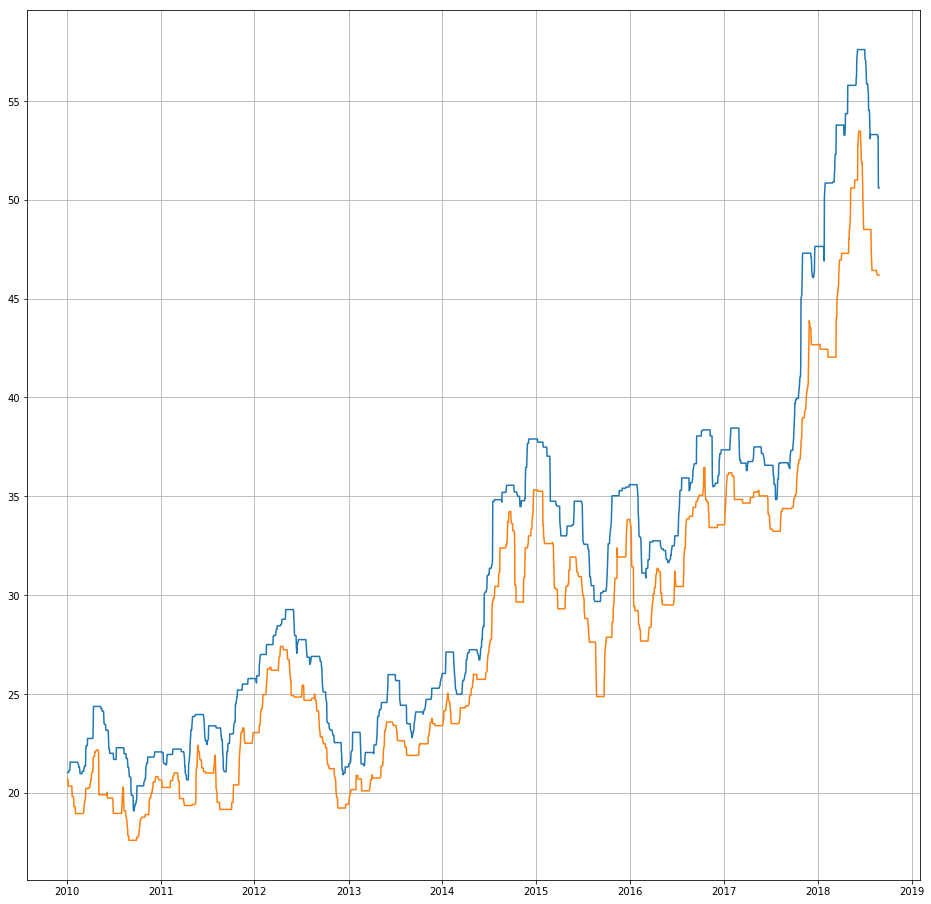

In [14]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(result['HighestHigh'])
plt.plot(result['LowestLow'])
plt.grid(True)

In [15]:
scaler = prep.MaxAbsScaler().fit(result[['ATR']].values)
result['ATR_Scaled'] = scaler.transform(result[['ATR']].values)

scaler = prep.MaxAbsScaler().fit(result[['TSI']].values)
result['TSI_Scaled'] = scaler.transform(result[['TSI']].values)

scaler = prep.MaxAbsScaler().fit(result[['OBV']].values)
result['OBV_Scaled'] = scaler.transform(result[['OBV']].values)

result['TradingRange'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['TradingRange']].values)
result['TradingRange_Scaled'] = scaler.transform(result[['TradingRange']].values)

scaler = prep.MaxAbsScaler().fit(result[['HighestHigh']].values)
result['HighestHigh_Scaled'] = scaler.transform(result[['HighestHigh']].values)

scaler = prep.MaxAbsScaler().fit(result[['LowestLow']].values)
result['LowestLow_Scaled'] = scaler.transform(result[['LowestLow']].values)

result['KF_mean'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['KF_mean']].values)
result['KFMean_Scaled'] = scaler.transform(result[['KF_mean']].values)

result['support_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['support_distance']].values)
result['support_distance_Scaled'] = scaler.transform(result[['support_distance']].values)

result['resistance_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['resistance_distance']].values)
result['resistance_distance_Scaled'] = scaler.transform(result[['resistance_distance']].values)

result = result.iloc[5:]

In [16]:
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(-1,0)
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(0,0.00000001)
result = result.drop('TSI', axis=1)
result = result.drop('ATR', axis=1)
result = result.drop('OBV', axis=1)
result = result.drop('TradingRange', axis=1)
result = result.drop('HighestHigh', axis=1)
result = result.drop('LowestLow', axis=1)

# Insert learning target / n-step ahead returns

In [19]:
# Shift to n period to predict next n period
predict_step = 3
y = result.shift(periods=predict_step)
y.fillna(0, inplace=True)
y = y['Close_logReturns']
result['Target'] = y

In [20]:
train_data = result.drop(['Open', 'High','Low','Close','Volume','MSFT','AMZN','NVDA','GOOG','NFLX'
                          ,'EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y'
                          ,'Tnote_10y','support_distance','resistance_distance'], axis=1)

# correlation to weekdays 

Text(0.5,1,'Bar 0 = Monday')

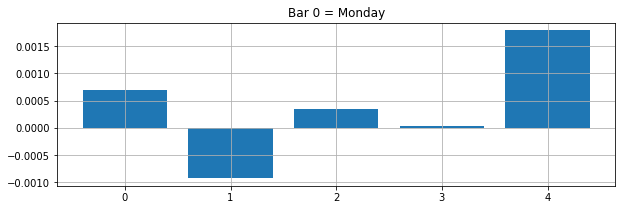

In [24]:
wkdays = train_data.replace(9,0).groupby(['Weekday'])['Target'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(wkdays.index,wkdays)
plt.grid()
plt.title('Bar 0 = Monday')

In [26]:
train_data = train_data.dropna()

In [27]:
print("result datapoints:" + str(len(result)) + ", train datapoints:"+ str(len(train_data)))

result datapoints:2177, train datapoints:2134


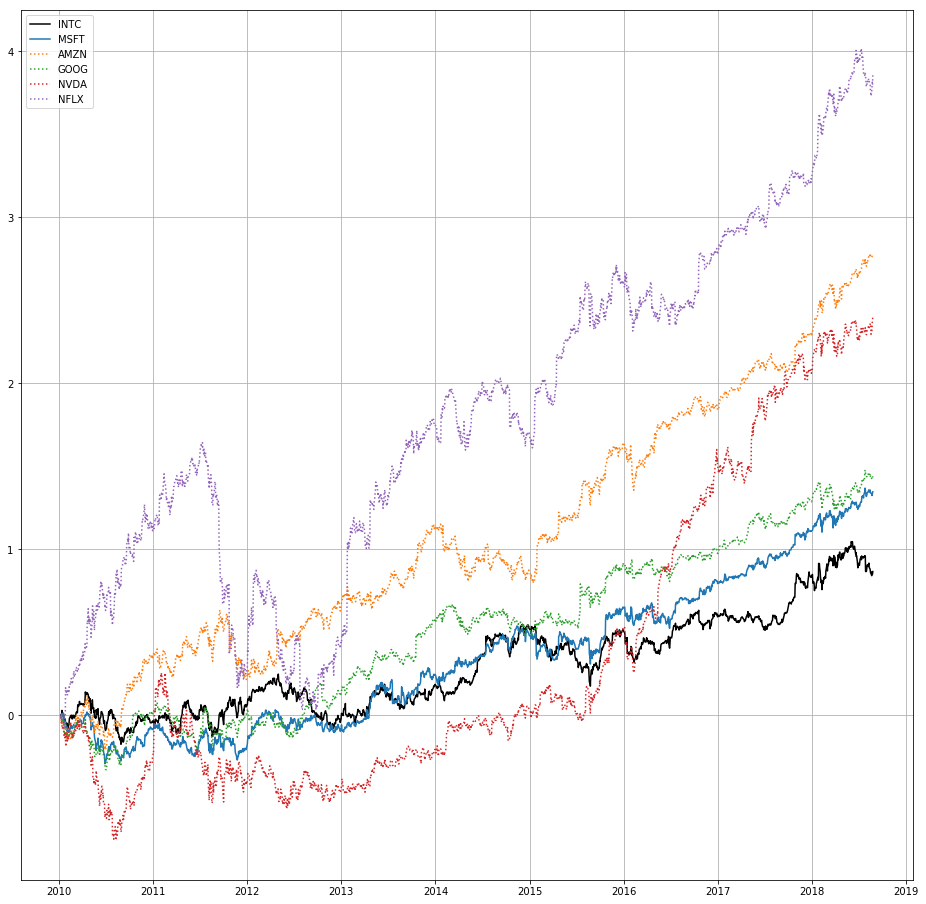

In [28]:
# Plot intel log returns to other 
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['AMZN_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['GOOG_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NFLX_logReturns']]),linestyle =':')
plt.legend(['INTC','MSFT','AMZN','GOOG','NVDA','NFLX','FB'], loc='upper left')
plt.grid(True)
plt.show()

# Plot correlation heat map

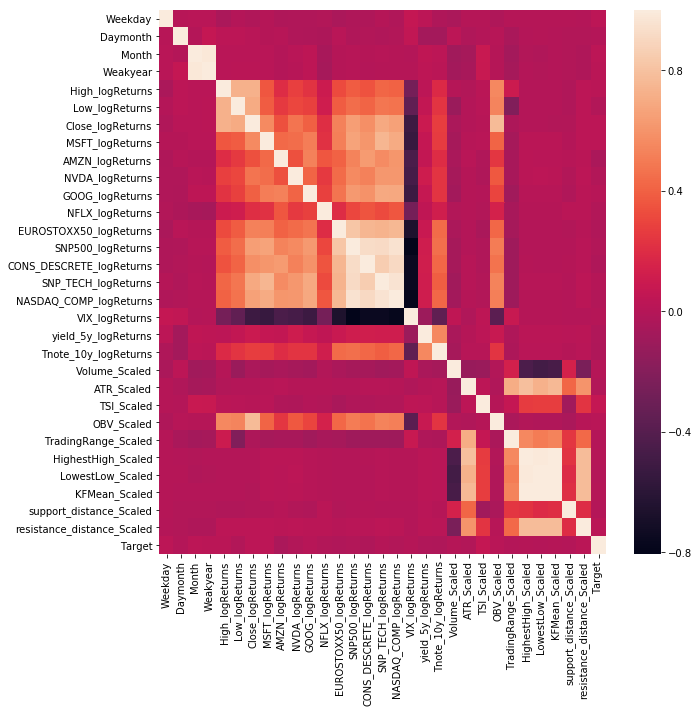

In [29]:
train_data = train_data.drop(['KF_mean','VIX'], axis=1)
corr = train_data.corr()
size = 10
fig, ax = plt.subplots(figsize=(size, size))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# properties of train_data

In [30]:
print ("Train dataset:")
print ("Number of data points: ", len(train_data.index))
print ("Number of days: ", train_data.index.nunique())
print ("Number of features: ", train_data.shape[1] - 5)
n_features = train_data.shape[1] - 5
# The sparsity is the subdivision of each side of a n_feature dimensional 
# cube that would result in a single observation per subdivision on average.
# The lower it is, the harder you’ll be hit by the curse of dimensionality. 
# It gives an idea of the density of the samples adjusted for the number of features. 
# Despite the large number of samples and reasonable number of features, we only need to cut the 
# hypercube x times along each axis on average to isolate each sample.
print ("Sparsity of the training data: " +  str(np.exp(np.log(train_data.shape[0])/n_features)))

Train dataset:
Number of data points:  2134
Number of days:  2134
Number of features:  26
Sparsity of the training data: 1.3429070043848792


In [31]:
train_data

Weekday  Daymonth  Month  Weakyear  High_logReturns  \
Date                                                              
2010-01-11        9        11      1         2         0.012369   
2010-01-12        1        12      1         2        -0.011891   
2010-01-13        2        13      1         2         0.008576   
2010-01-14        3        14      1         2         0.022051   
2010-01-15        4        15      1         2        -0.006985   
2010-01-19        1        19      1         3        -0.010806   
2010-01-20        2        20      1         3        -0.001418   
2010-01-21        3        21      1         3         0.008009   
2010-01-22        4        22      1         3        -0.024704   
2010-01-25        9        25      1         4        -0.010152   
2010-01-26        1        26      1         4        -0.009766   
2010-01-27        2        27      1         4        -0.002456   
2010-01-28        3        28      1         4         0.002947   
2010-01-29        4        29      1         4        -0.007878   
2010-02-01        9         1      2         5        -0.024013   
2010-02-02        1         2      2         5         0.014577   
2010-02-03        2         3      2         5        -0.008016   
2010-02-04        3         4      2         5        -0.015206   
2010-02-05        4         5      2         5         0.000000   
2010-02-08        9         8      2         6         0.010668   
2010-02-09        1         9      2         6         0.005040   
2010-02-10        2        10      2         6        -0.001006   
2010-02-11        3        11      2         6         0.016472   
2010-02-12        4        12      2         6         0.023484   
2010-02-16        1        16      2         7         0.008187   
2010-02-17        2        17      2         7         0.000480   
2010-02-18        3        18      2         7        -0.000480   
2010-02-19        4        19      2         7         0.005739   
2010-02-22        9        22      2         8        -0.000477   
2010-02-23        1        23      2         8        -0.000477   
...             ...       ...    ...       ...              ...   
2018-07-16        9        16      7        29        -0.001909   
2018-07-17        1        17      7        29        -0.008445   
2018-07-18        2        18      7        29         0.001733   
2018-07-19        3        19      7        29         0.000769   
2018-07-20        4        20      7        29         0.001153   
2018-07-23        9        23      7        30         0.008224   
2018-07-24        1        24      7        30         0.015123   
2018-07-25        2        25      7        30        -0.016076   
2018-07-26        3        26      7        30         0.013822   
2018-07-27        4        27      7        30        -0.077789   
2018-07-30        9        30      7        31        -0.024901   
2018-07-31        1        31      7        31         0.014276   
2018-08-01        2         1      8        31         0.004714   
2018-08-02        3         2      8        31         0.012395   
2018-08-03        4         3      8        31         0.005237   
2018-08-06        9         6      8        32        -0.009486   
2018-08-07        1         7      8        32         0.010490   
2018-08-08        2         8      8        32         0.006002   
2018-08-09        3         9      8        32         0.009332   
2018-08-10        4        10      8        32        -0.028668   
2018-08-13        9        13      8        33         0.001423   
2018-08-14        1        14      8        33        -0.009796   
2018-08-15        2        15      8        33        -0.015709   
2018-08-16        3        16      8        33        -0.001042   
2018-08-17        4        17      8        33        -0.011748   
2018-08-20        9        20      8        34        -0.005714   
2018-08-21        1        21      8        34         0.01

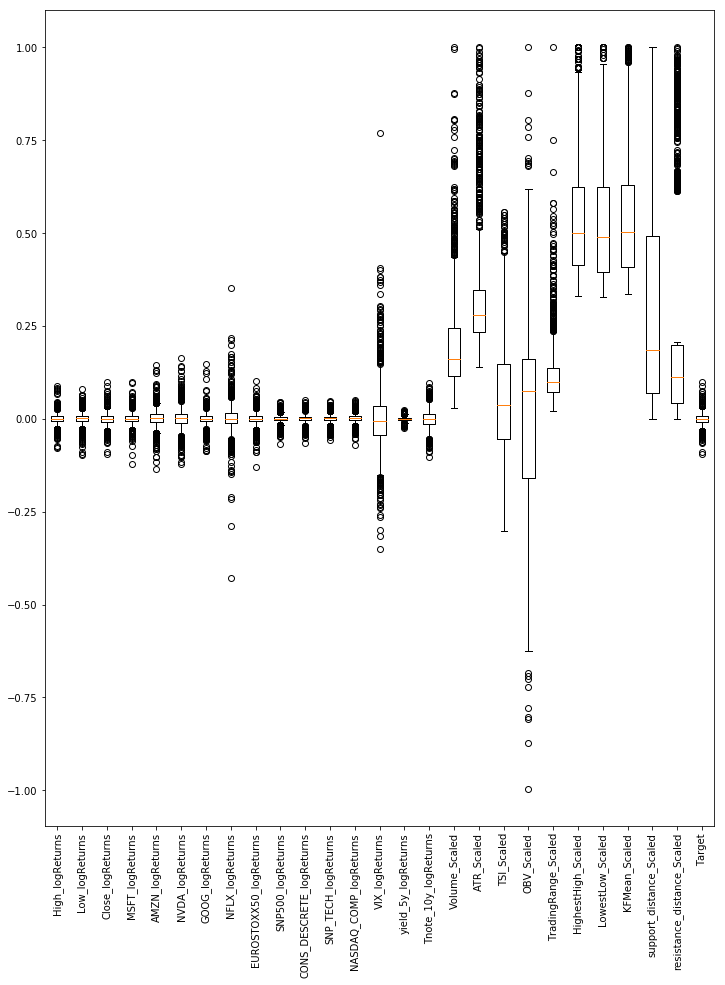

In [32]:
plt.figure(figsize=(12,15))
dat = train_data.drop(['Weekday','Daymonth','Weakyear','Month'],axis=1)
plt.boxplot(dat.values, labels = dat.columns)
plt.xticks(rotation=90)
plt.show()

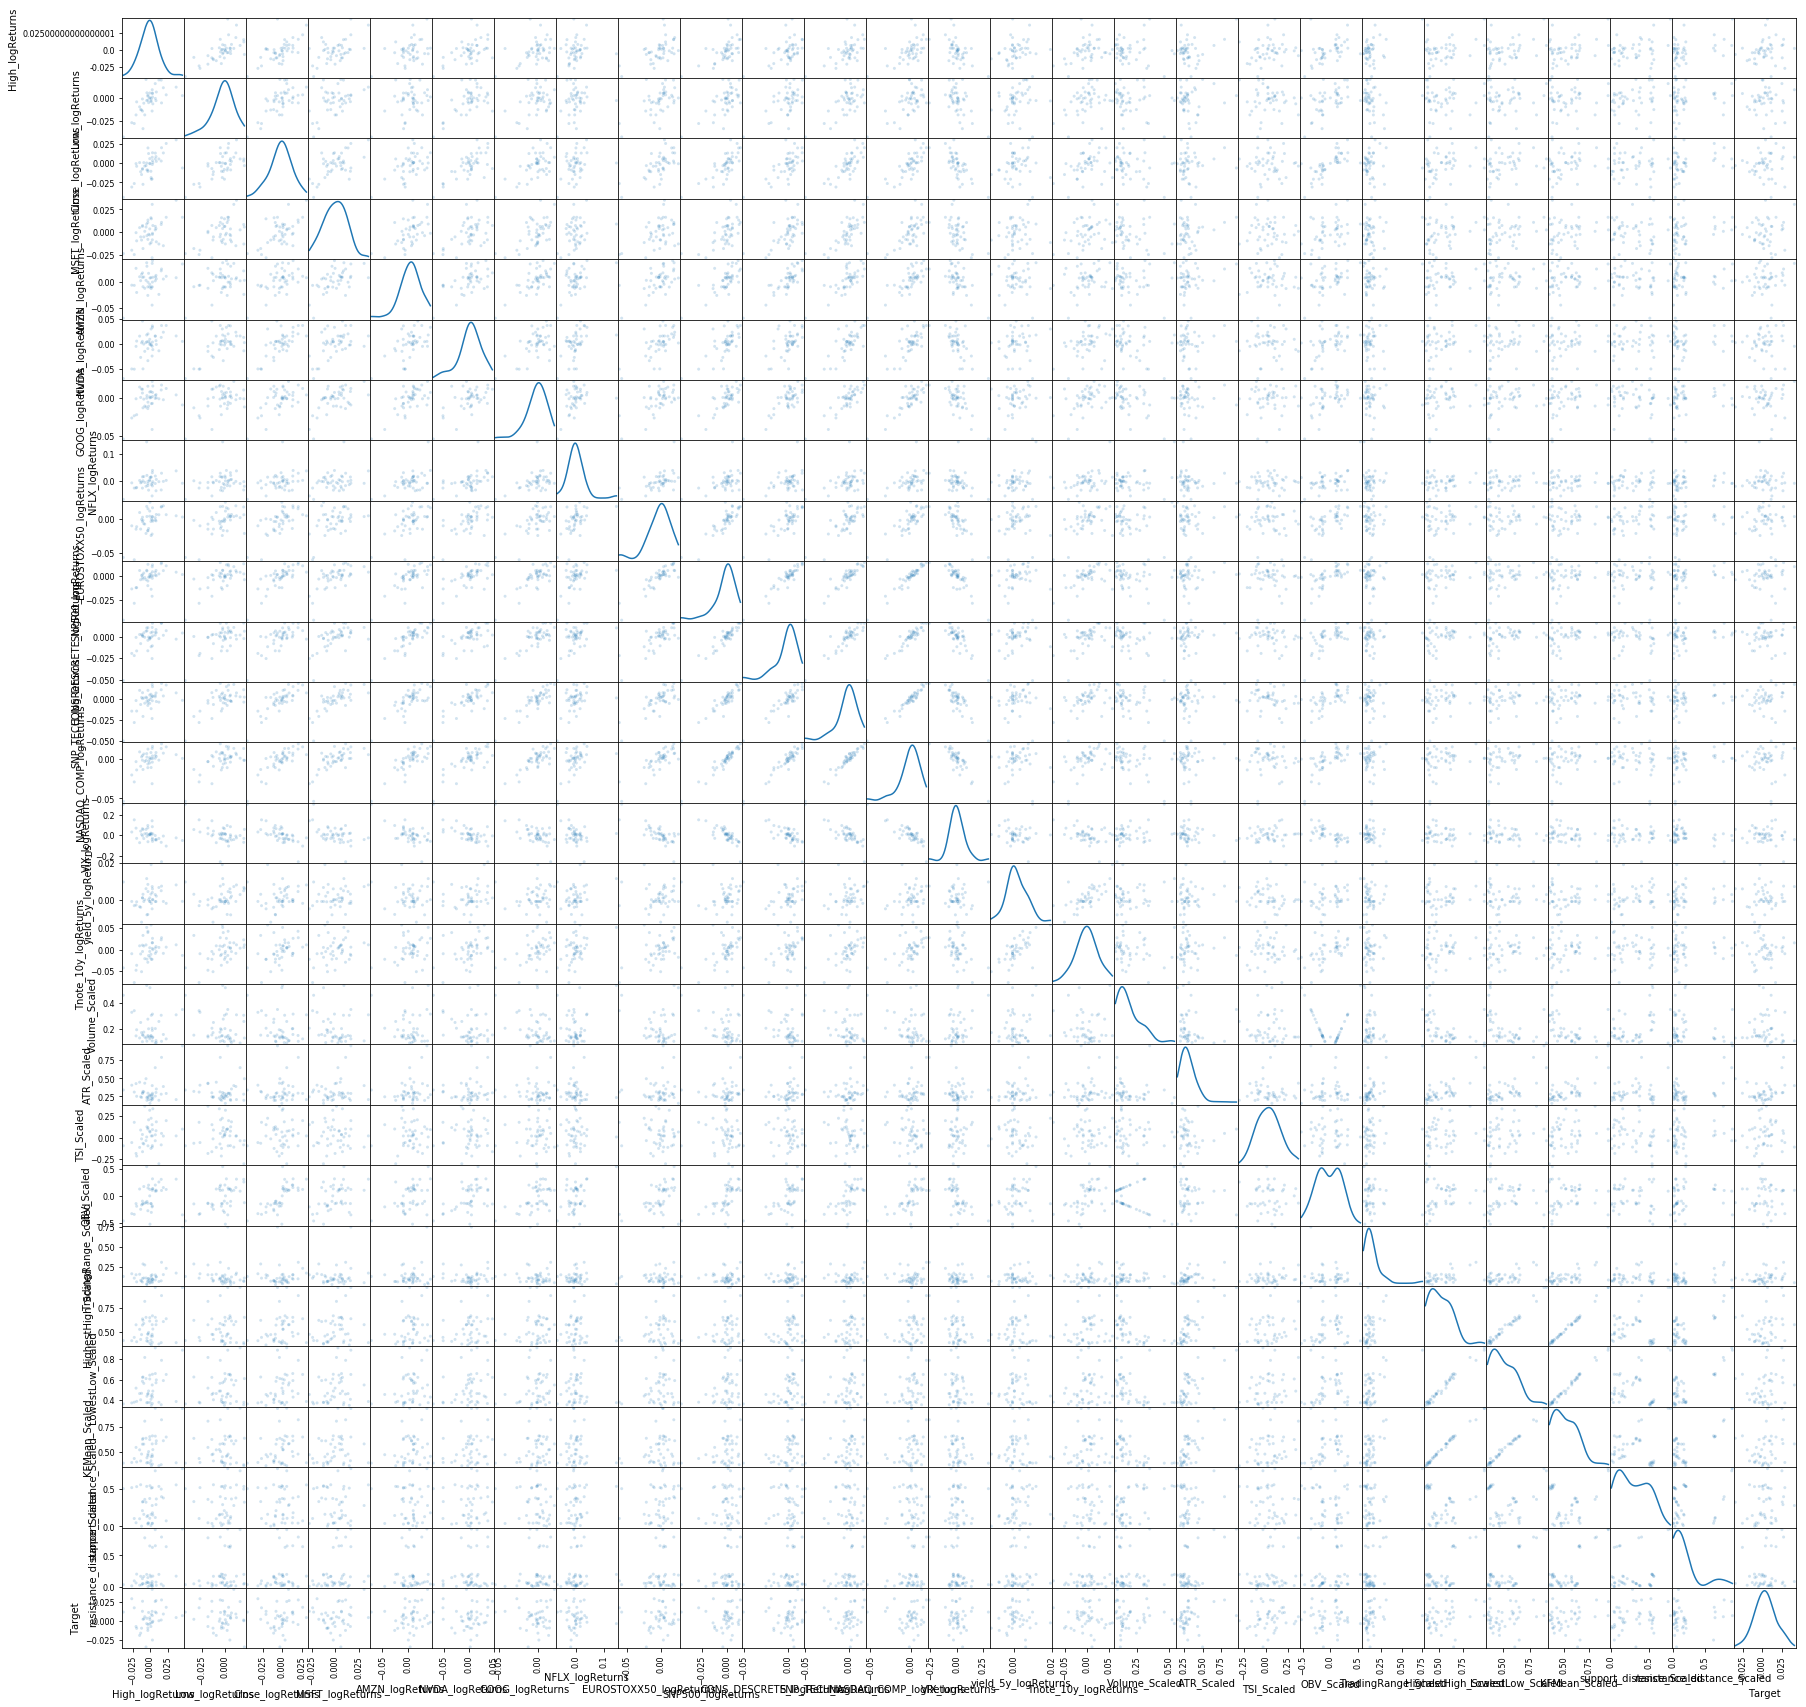

In [33]:
pd.plotting.scatter_matrix(train_data.iloc[::50].select_dtypes(include=['int', 'float']), alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()

In [34]:
train_data.describe()

Weekday     Daymonth        Month     Weakyear  High_logReturns  \
count  2134.000000  2134.000000  2134.000000  2134.000000      2134.000000   
mean      3.681350    15.768510     6.348172    25.778819         0.000391   
std       2.706742     8.755673     3.373757    14.709463         0.013179   
min       1.000000     1.000000     1.000000     1.000000        -0.077789   
25%       2.000000     8.000000     3.000000    13.000000        -0.006184   
50%       3.000000    16.000000     6.000000    25.000000         0.000436   
75%       4.000000    23.000000     9.000000    38.000000         0.007317   
max       9.000000    31.000000    12.000000    53.000000         0.088426   

       Low_logReturns  Close_logReturns  MSFT_logReturns  AMZN_logReturns  \
count     2134.000000       2134.000000      2134.000000      2134.000000   
mean         0.000394          0.000406         0.000631         0.001301   
std          0.014085          0.015021         0.014186         0.019363   
min         -0.096204         -0.095432        -0.121033        -0.135325   
25%         -0.006500         -0.007703        -0.006708        -0.008091   
50%          0.000949          0.000540         0.000356         0.001120   
75%          0.007789          0.008547         0.007999         0.011688   
max          0.079817          0.100315         0.099413         0.146225   

       NVDA_logReturns  GOOG_logReturns  NFLX_logReturns  \
count      2134.000000      2134.000000      2134.000000   
mean          0.001126         0.000675         0.001807   
std           0.023781         0.015120         0.033477   
min          -0.122573        -0.087493        -0.429179   
25%          -0.010861        -0.006297        -0.012279   
50%           0.001092         0.000477         0.000478   
75%           0.012902         0.008341         0.016310   
max           0.164038         0.148872         0.352230   

       EUROSTOXX50_logReturns  SNP500_logReturns  CONS_DESCRETE_logReturns  \
count             2134.000000        2134.000000               2134.000000   
mean                -0.000012           0.000464                  0.000638   
std                  0.015693           0.009299                  0.010162   
min                 -0.130242          -0.068958                 -0.064795   
25%                 -0.006843          -0.003257                 -0.004271   
50%                  0.000777           0.000611                  0.001154   
75%                  0.007897           0.005036                  0.006228   
max                  0.102831           0.046317                  0.050889   

       SNP_TECH_logReturns  NASDAQ_COMP_logReturns  VIX_logReturns  \
count          2134.000000             2134.000000     2134.000000   
mean              0.000578                0.000610       -0.000644   
std               0.010236                0.010552        0.077070   
min              -0.057957               -0.071489       -0.350589   
25%              -0.004079               -0.003905       -0.042356   
50%               0.000939                0.000988       -0.006037   
75%               0.006013                0.006298        0.033982   
max               0.049169                0.051592        0.768245   

       yield_5y_logReturns  Tnote_10y_logReturns  Volume_Scaled   ATR_Scaled  \
count          2134.000000           2134.000000    2134.000000  2134.000000   
mean              0.000003             -0.000116       0.196288     0.318872   
std               0.004947              0.021709       0.116620     0.140744   
min              -0.024718             -0.102809       0.029617     0.139119   
25%              -0.002962             -0.013304       0.115348     0.234765   
50%               0.000000              0.000000       0.161294     0.278835   
75%               0.002939              0.012848       0.244435     0.346362   
max               0.023222              0.096277       1.000000     1.000000   

        TSI_Scaled

In [35]:
df_corr = train_data[['Close_logReturns','MSFT_logReturns','AMZN_logReturns','GOOG_logReturns','NVDA_logReturns',
                       'NFLX_logReturns']]

Close_logReturns  MSFT_logReturns  AMZN_logReturns  \
Close_logReturns          1.000000         0.560705         0.339576   
MSFT_logReturns           0.560705         1.000000         0.433075   
AMZN_logReturns           0.339576         0.433075         1.000000   
GOOG_logReturns           0.394866         0.508954         0.527481   
NVDA_logReturns           0.473506         0.446074         0.341050   
NFLX_logReturns           0.204573         0.223703         0.360026   

                  GOOG_logReturns  NVDA_logReturns  NFLX_logReturns  
Close_logReturns         0.394866         0.473506         0.204573  
MSFT_logReturns          0.508954         0.446074         0.223703  
AMZN_logReturns          0.527481         0.341050         0.360026  
GOOG_logReturns          1.000000         0.407972         0.285875  
NVDA_logReturns          0.407972         1.000000         0.256807  
NFLX_logReturns          0.285875         0.256807         1.000000

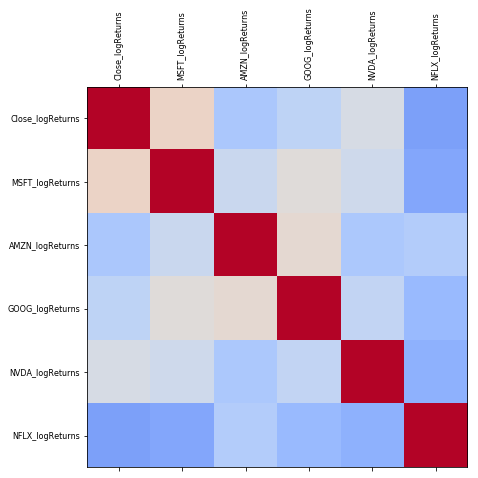

In [36]:
df = df_corr.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

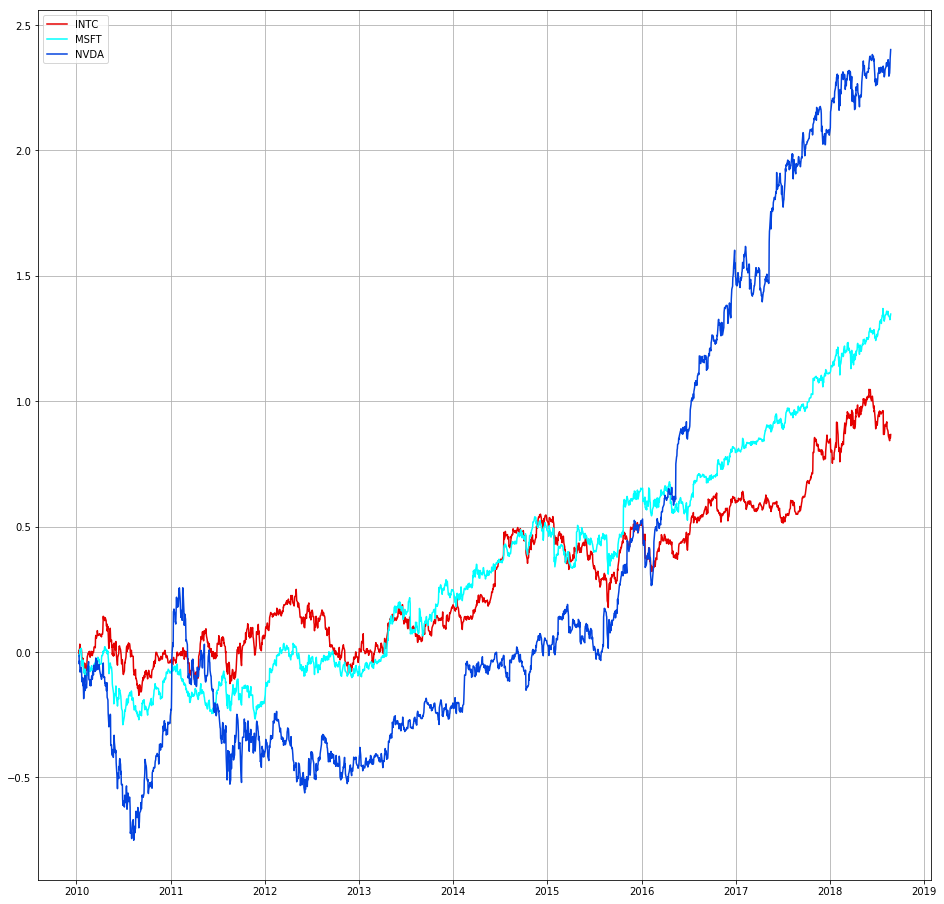

In [37]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),color='xkcd:blue',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','MSFT','NVDA'], loc='upper left')

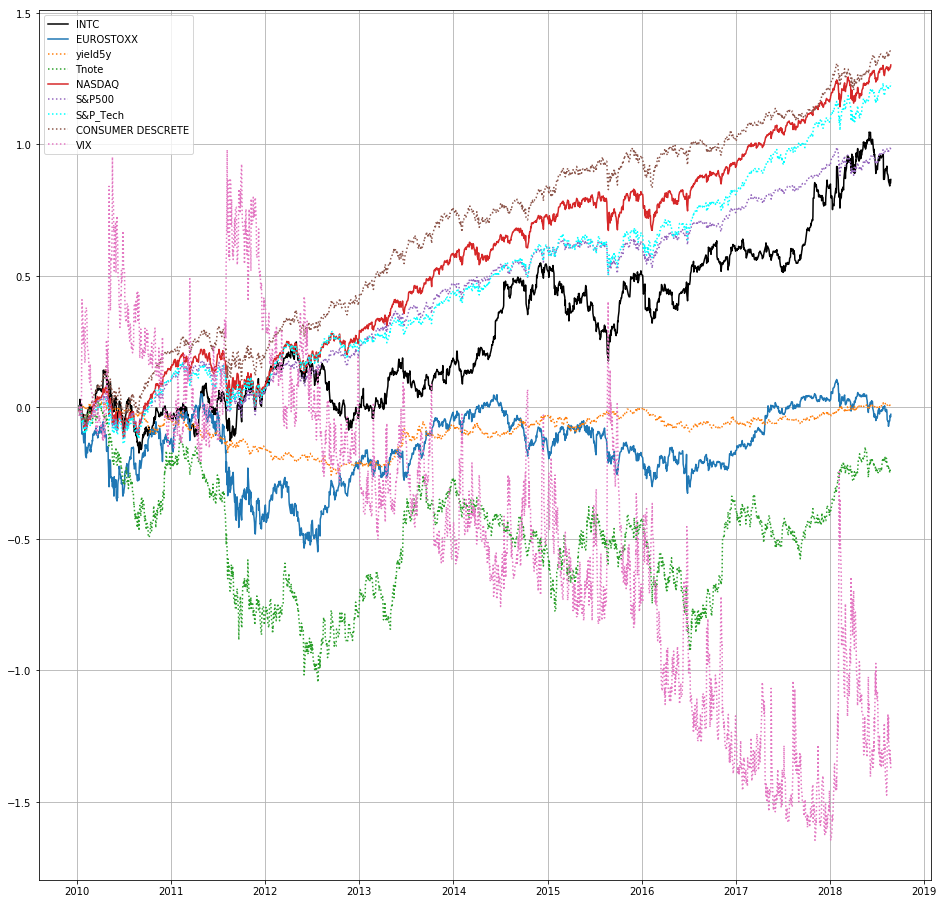

In [38]:
# Plot intel log returns to macro
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['EUROSTOXX50_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['yield_5y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['Tnote_10y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP500_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.plot(np.cumsum(train_data[['CONS_DESCRETE_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),linestyle =':')
plt.legend(['INTC','EUROSTOXX','yield5y','Tnote','NASDAQ','S&P500','S&P_Tech','CONSUMER DESCRETE','VIX'], loc='upper left')
plt.grid(True)
plt.show()

In [39]:
df_corr2 = train_data[['Close_logReturns','EUROSTOXX50_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','NASDAQ_COMP_logReturns',
                       'SNP500_logReturns','SNP_TECH_logReturns','CONS_DESCRETE_logReturns','VIX_logReturns']]

Close_logReturns  EUROSTOXX50_logReturns  \
Close_logReturns                  1.000000                0.523889   
EUROSTOXX50_logReturns            0.523889                1.000000   
yield_5y_logReturns               0.093792                0.085781   
Tnote_10y_logReturns              0.270743                0.439367   
NASDAQ_COMP_logReturns            0.661358                0.759439   
SNP500_logReturns                 0.645307                0.822652   
SNP_TECH_logReturns               0.693057                0.737373   
CONS_DESCRETE_logReturns          0.583290                0.746820   
VIX_logReturns                   -0.515206               -0.661345   

                          yield_5y_logReturns  Tnote_10y_logReturns  \
Close_logReturns                     0.093792              0.270743   
EUROSTOXX50_logReturns               0.085781              0.439367   
yield_5y_logReturns                  1.000000              0.554740   
Tnote_10y_logReturns                 0.554740              1.000000   
NASDAQ_COMP_logReturns               0.116023              0.423639   
SNP500_logReturns                    0.116047              0.454829   
SNP_TECH_logReturns                  0.115181              0.393161   
CONS_DESCRETE_logReturns             0.123356              0.427634   
VIX_logReturns                      -0.104240             -0.354173   

                          NASDAQ_COMP_logReturns  SNP500_logReturns  \
Close_logReturns                        0.661358           0.645307   
EUROSTOXX50_logReturns                  0.759439           0.822652   
yield_5y_logReturns                     0.116023           0.116047   
Tnote_10y_logReturns                    0.423639           0.454829   
NASDAQ_COMP_logReturns                  1.000000           0.952522   
SNP500_logReturns                       0.952522           1.000000   
SNP_TECH_logReturns                     0.958843           0.918891   
CONS_DESCRETE_logReturns                0.914502           0.924143   
VIX_logReturns                         -0.777327          -0.805150   

                          SNP_TECH_logReturns  CONS_DESCRETE_logReturns  \
Close_logReturns                     0.693057                  0.583290   
EUROSTOXX50_logReturns               0.737373                  0.746820   
yield_5y_logReturns                  0.115181                  0.123356   
Tnote_10y_logReturns                 0.393161                  0.427634   
NASDAQ_COMP_logReturns               0.958843                  0.914502   
SNP500_logReturns                    0.918891                  0.924143   
SNP_TECH_logReturns                  1.000000                  0.855140   
CONS_DESCRETE_logReturns             0.855140                  1.000000   
VIX_logReturns                      -0.751694                 -0.749940   

                          VIX_logReturns  
Close_logReturns               -0.515206  
EUROSTOXX50_logReturns         -0.661345  
yield_5y_logReturns            -0.104240  
Tnote_10y_logReturns           -0.354173  
NASDAQ_COMP_logReturns         -0.777327  
SNP500_logReturns              -0.805150  
SNP_TECH_logReturns            -0.751694  
CONS_DESCRETE_logReturns       -0.749940  
VIX_logReturns                  1.000000

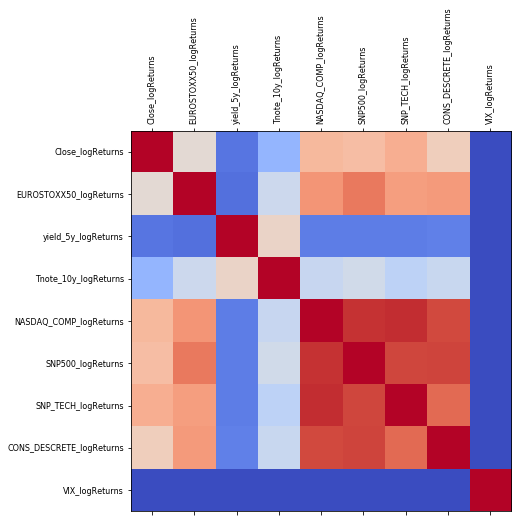

In [40]:
df = df_corr2.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sign
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sign
  


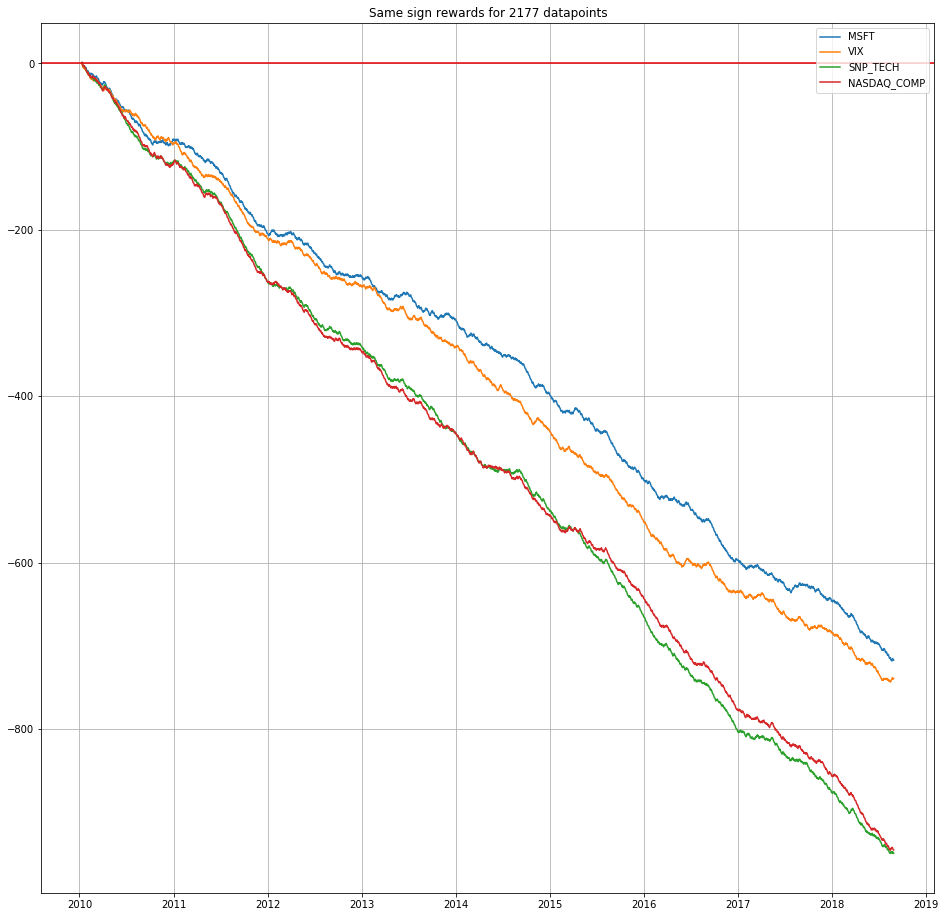

In [41]:
# MSFT same sign
diff_sign = np.sign(result['Close_logReturns']) != np.sign(result['MSFT_logReturns'])
diff_sign = diff_sign.replace(True,1).replace(False,-1)

# VIX opposite sign
diff_sign_vix = np.sign(result['Close_logReturns']) != np.sign(result['VIX_logReturns'])
diff_sign_vix = diff_sign_vix.replace(True,-1).replace(False,1)

# SNP Tech same sign
diff_sign_spt = np.sign(result['Close_logReturns']) != np.sign(result['SNP_TECH_logReturns'])
diff_sign_spt = diff_sign_spt.replace(True,1).replace(False,-1)

# Nasdaq Composite same sign
diff_sign_ndc = np.sign(result['Close_logReturns']) != np.sign(result['NASDAQ_COMP_logReturns'])
diff_sign_ndc = diff_sign_ndc.replace(True,1).replace(False,-1)

plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(diff_sign))
plt.plot(np.cumsum(diff_sign_vix))
plt.plot(np.cumsum(diff_sign_spt))
plt.plot(np.cumsum(diff_sign_ndc))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.legend(['MSFT','VIX','SNP_TECH','NASDAQ_COMP'], loc='upper right')
plt.grid(True)
plt.title("Same sign rewards for " + str(len(diff_sign)) +" datapoints")
plt.show()

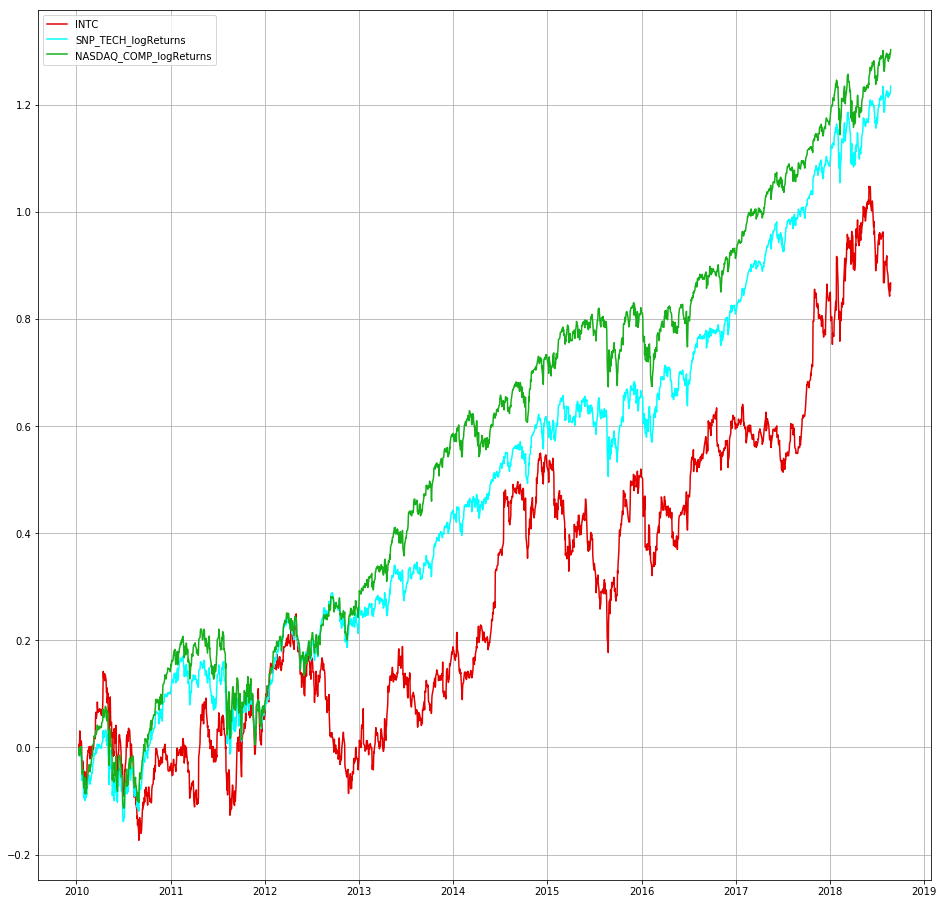

In [42]:
# Plot cumsum of returns Close,SNP_Tech, Nasdaq Comp
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),color='xkcd:green',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','SNP_TECH_logReturns','NASDAQ_COMP_logReturns'], loc='upper left')

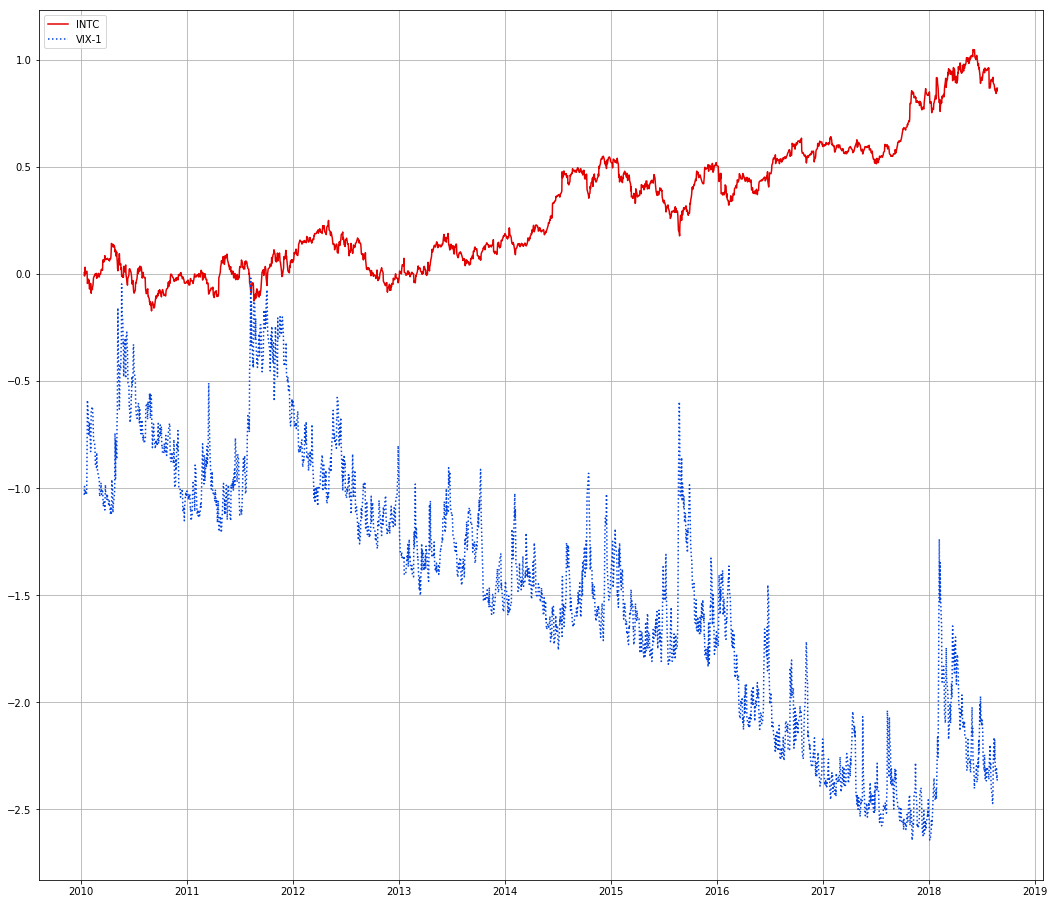

In [43]:
#Plot Cumsum close and vix
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['VIX_logReturns']])-1,color='xkcd:blue',linestyle =':')
plt.grid(True,which ='both')
plt.legend(['INTC','VIX-1'], loc='upper left')

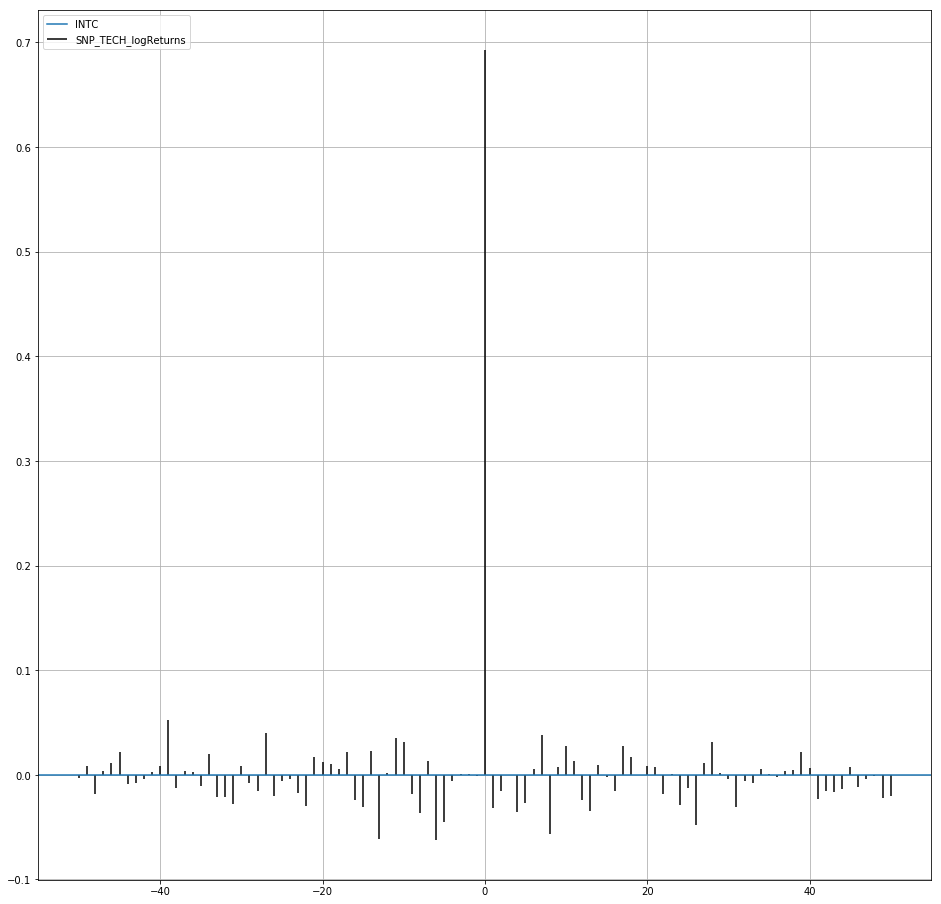

In [44]:
# show lagged cross correlation between intc and highest corr coeff
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['SNP_TECH_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','SNP_TECH_logReturns'], loc='upper left')
plt.show()

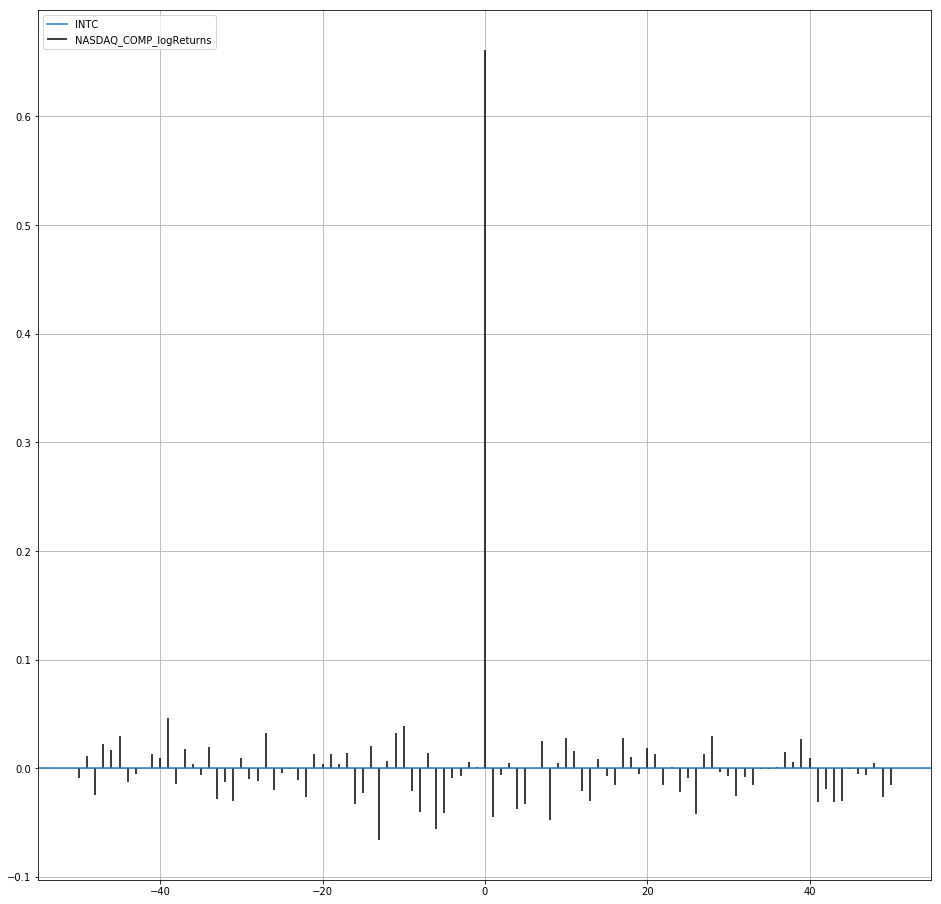

In [45]:
# show lagged cross correlation with NASDAQ_COMP
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['NASDAQ_COMP_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','NASDAQ_COMP_logReturns'], loc='upper left')
plt.show()

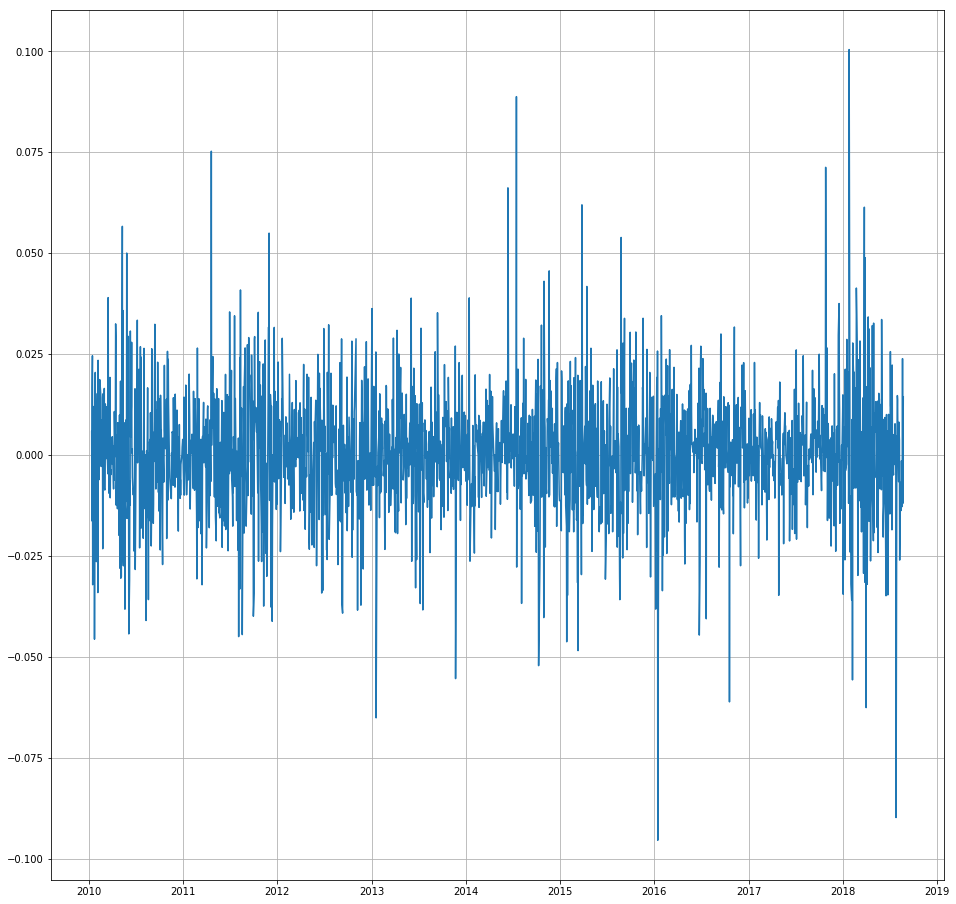

In [46]:
# Show distribution of log returns of INTC
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['Close_logReturns']])
plt.grid(True)

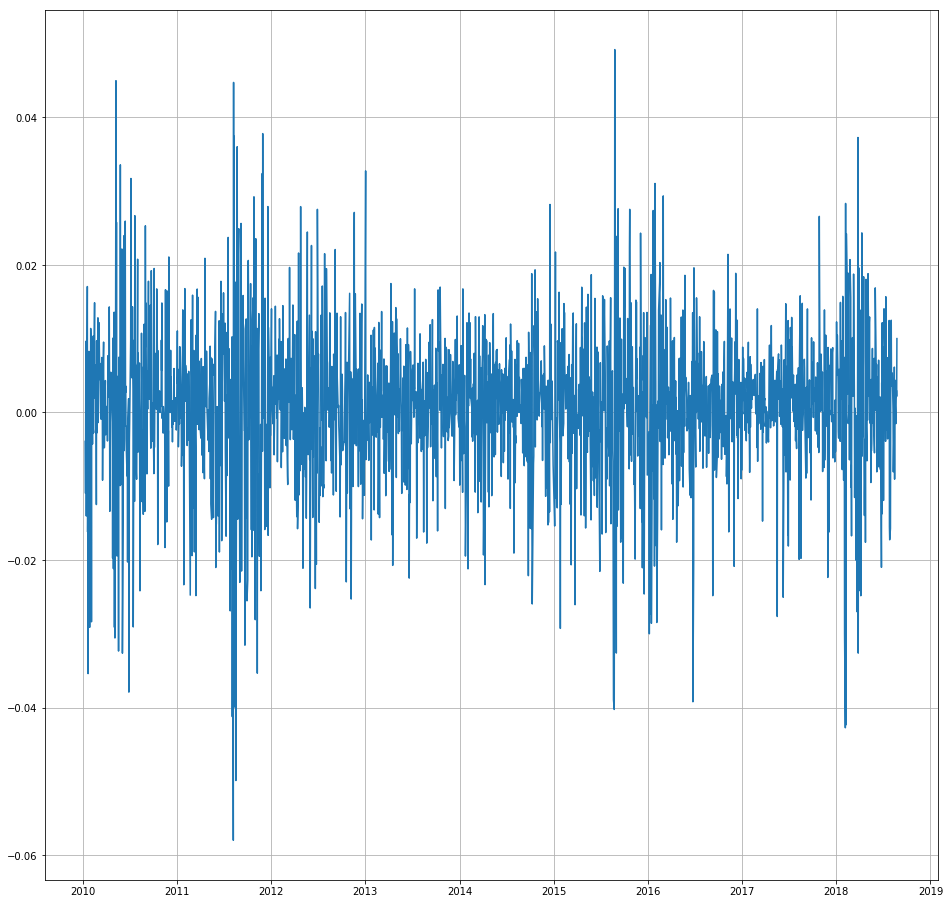

In [47]:
# Show distribution of log returns of SNP Tech
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['SNP_TECH_logReturns']])
plt.grid(True)

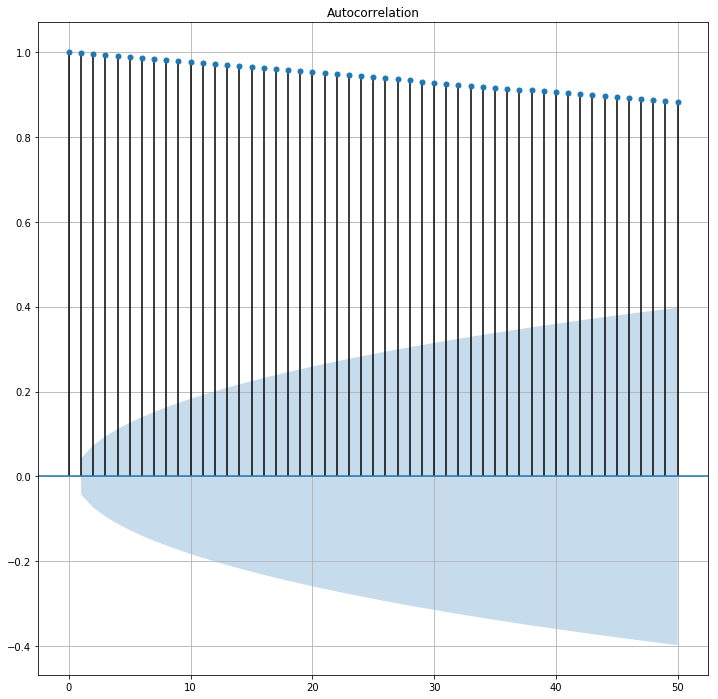

In [48]:
# plot auto correlation with itself
from statsmodels.graphics.tsaplots import plot_acf
intc_arr = np.array(np.cumsum(train_data[['Close_logReturns']]))
intc_arr = intc_arr.ravel()
series = intc_arr
plt.rc("figure",figsize=(12,12))
plot_acf(series, lags=50,use_vlines=True)
plt.grid(True)

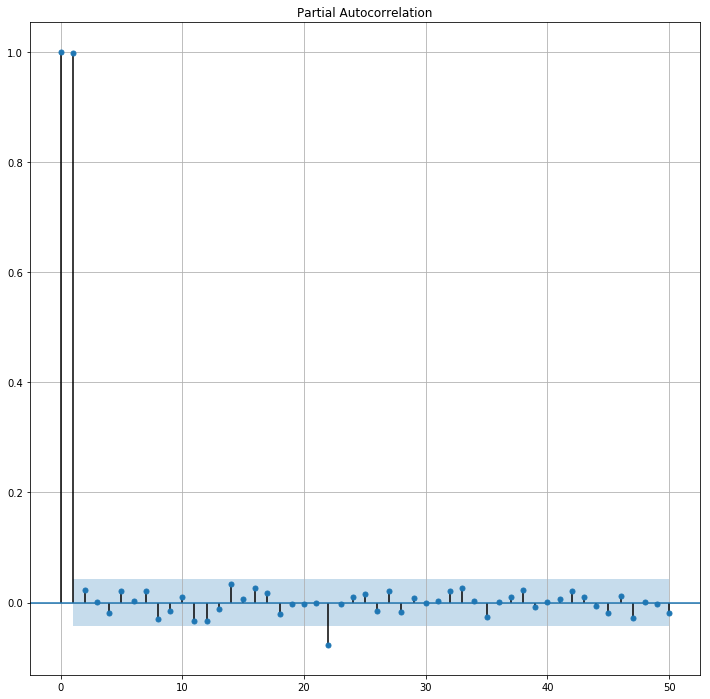

In [49]:
# plot partial auto correlation of INTC
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure",figsize=(12,12))
plot_pacf(series, lags=50,use_vlines=True)
plt.grid(True)

In [50]:
train_data.shape

(2134, 31)

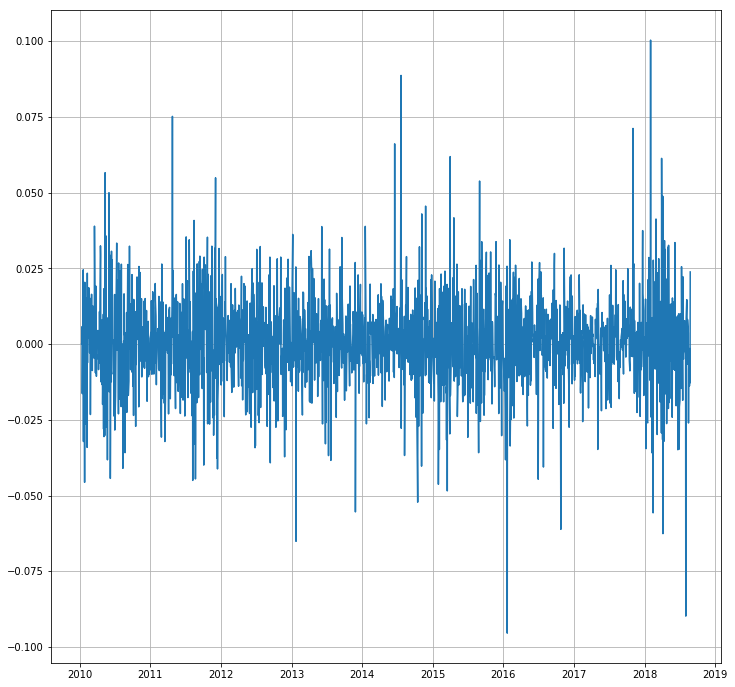

In [51]:
plt.plot(train_data['Target'])
plt.grid(True)

In [52]:
# clip data and cut extremes
train_data['Target'] = train_data['Target'].clip(-0.04,0.04)

In [53]:
train_data_dropped = train_data.drop(['High_logReturns','Low_logReturns','Close_logReturns','AMZN_logReturns','NVDA_logReturns',
                             'GOOG_logReturns','NFLX_logReturns','EUROSTOXX50_logReturns',
                             'SNP500_logReturns','CONS_DESCRETE_logReturns','yield_5y_logReturns','Tnote_10y_logReturns',
                             'resistance_distance_Scaled','support_distance_Scaled'
                             ], axis=1)

y = train_data_dropped['Target']

# drop target variable from dataframe
train_data_final = train_data_dropped.drop(['Target'], axis=1)

# Train and test on ExtraTrees
X_train, X_test, y_train, y_test = ms.train_test_split(train_data_final, y, test_size=0.3)


In [56]:
data_correlations

Value
ATR_Scaled vs Target             -0.010350
Daymonth vs Target               -0.011468
HighestHigh_Scaled vs Target     -0.000602
KFMean_Scaled vs Target           0.000599
LowestLow_Scaled vs Target       -0.001585
MSFT_logReturns vs Target         0.025304
Month vs Target                   0.028845
NASDAQ_COMP_logReturns vs Target -0.009751
OBV_Scaled vs Target              0.012448
SNP_TECH_logReturns vs Target     0.000460
TSI_Scaled vs Target              0.061546
TradingRange_Scaled vs Target    -0.012129
VIX_logReturns vs Target          0.006763
Volume_Scaled vs Target          -0.002145
Weakyear vs Target                0.024909
Weekday vs Target                 0.030693

# Correlation between feature and target

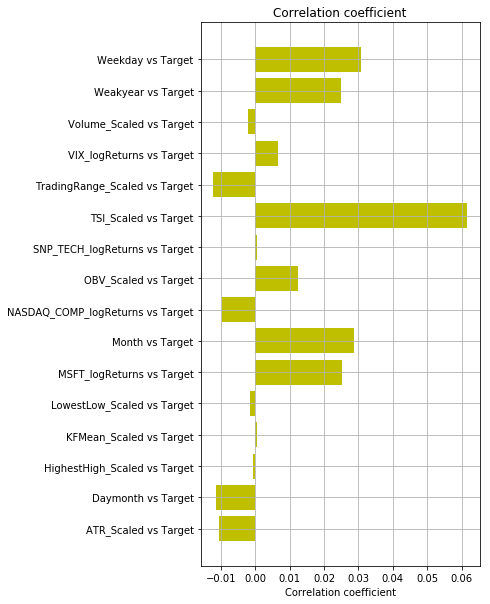

In [59]:
features = train_data_final.columns.tolist()
target = y.name

correlations = {}
for f in features:
    data_temp = train_data_dropped[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

width = 0.9
fig, ax = plt.subplots(figsize=(5,10))
rects = ax.barh(data_correlations.index, np.array(data_correlations['Value'].values), color='y')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.grid()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


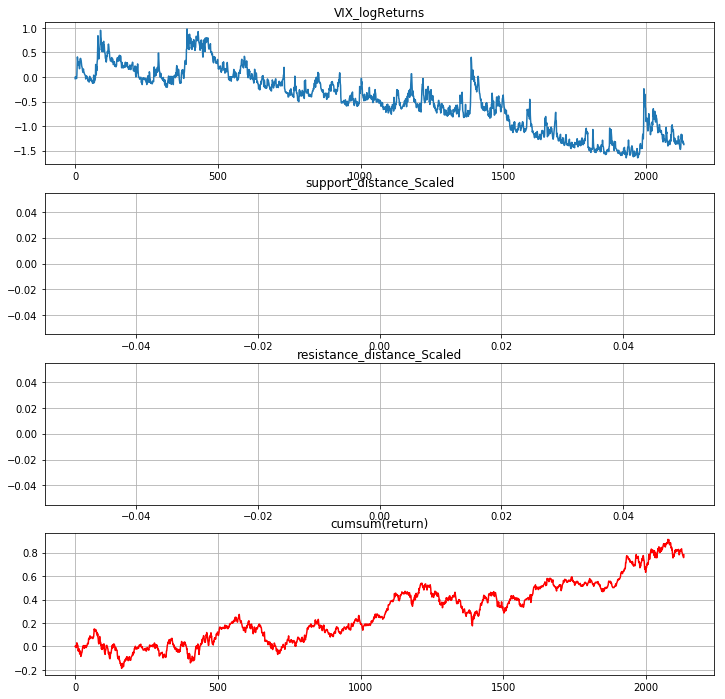

In [62]:
y = train_data_dropped.loc[:,['VIX_logReturns','support_distance_Scaled','resistance_distance_Scaled',target]].values
x = np.arange(y.shape[0])

%matplotlib inline
plt.rc("figure",figsize=(12,12))
plt.subplot(4,1,1)
plt.plot(x,np.cumsum(y[:,0]))
plt.title('VIX_logReturns')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,2)
plt.plot(x,(y[:,1]))
plt.title('support_distance_Scaled')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,3)
plt.plot(x,(y[:,2]))
plt.title('resistance_distance_Scaled')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,4)
plt.plot(x,np.cumsum(y[:,3]),'r')
plt.title('cumsum(return)')
plt.ylabel("")
plt.grid(True)
plt.show()

# train xgboost linear regression

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xgb = xgboost.XGBRegressor(eval_metric = 'mae')
# Learning rate in tree
learning_rate = [x/1000 for x in range(11, 310, 50)] 

# Number of trees in random forest
n_estimators = range(10,350,10)
# Maximum number of levels in tree
max_depth = range(3,12,2)
# A smaller value should be chosen because it is a highly imbalanced 
# class problem and leaf nodes can have smaller size groups.
min_child_weight = range(2,20,2)
# Method of selecting samples for training each tree
subsample = [i/10.0 for i in range(6,10)]

colsample_bytree = [i/10.0 for i in range(4,10)]

reg_alpha = [0.0001, 0.001, 0.1, 1, 100]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'reg_alpha' : reg_alpha
              }
xgb_model = RandomizedSearchCV(
    estimator = xgb, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 7, 
    verbose=1, 
    random_state=1001)

xgb_model.fit(X_train, y_train)


Fitting 7 folds for each of 100 candidates, totalling 700 fits


In [49]:
xgb_model.best_params_

{'subsample': 0.8,
 'reg_alpha': 1,
 'n_estimators': 280,
 'min_child_weight': 18,
 'max_depth': 3,
 'learning_rate': 0.061,
 'colsample_bytree': 0.6}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


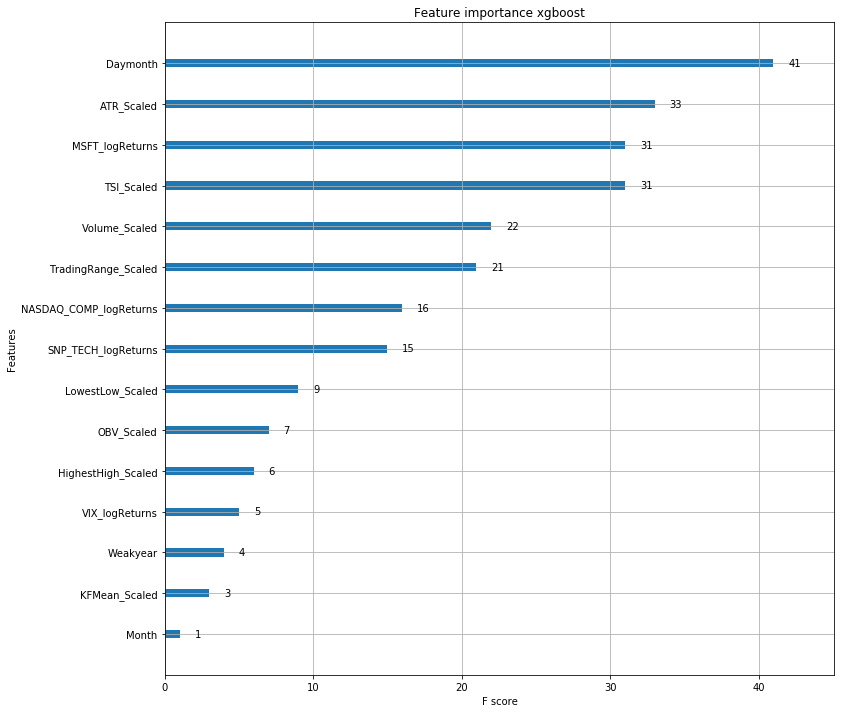

In [50]:
from xgboost import plot_importance
xgb_model.cv_results_['mean_train_score'].mean()
xgb = xgboost.XGBRegressor(**xgb_model.best_params_)
xgb.fit(X_train, y_train)
plt.rc("figure",figsize=(12,12))
plot_importance(xgb)
plt.title("Feature importance xgboost")
plt.show()

# Feature selection after training

0.01438405593115633

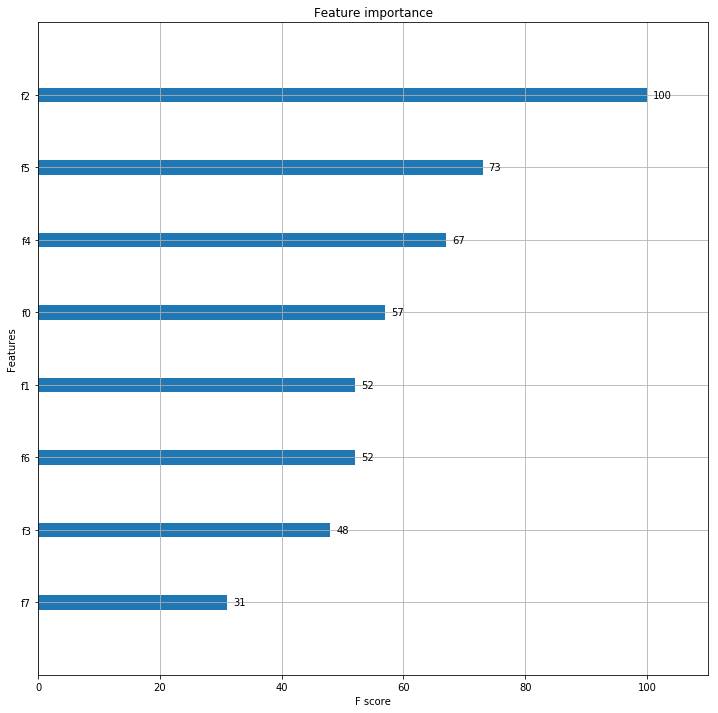

In [51]:
selection = fs.SelectFromModel(xgb, threshold="median", prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = xgboost.XGBRegressor()
# Fit with new features
selection_model.fit(select_X_train, y_train)
# Plot new importances
plot_importance(selection_model)

# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
actual_and_test = np.column_stack([y_test, y_pred])
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))
rms

# No feature selection and test

Coefficient of determination on training set: (R^2) 0.024543899345756848
Average coefficient of determination using 5-fold crossvalidation: -0.022449707025584374


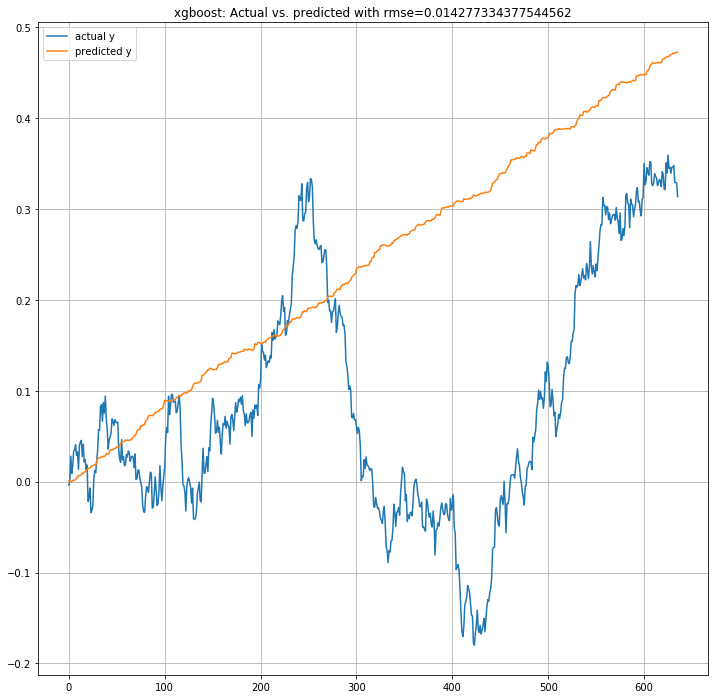

In [52]:
print ("Coefficient of determination on training set: (R^2)",xgb.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(xgb, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))

predicted_values = xgb.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("xgboost: Actual vs. predicted with rmse=" + str(rms) + "")
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

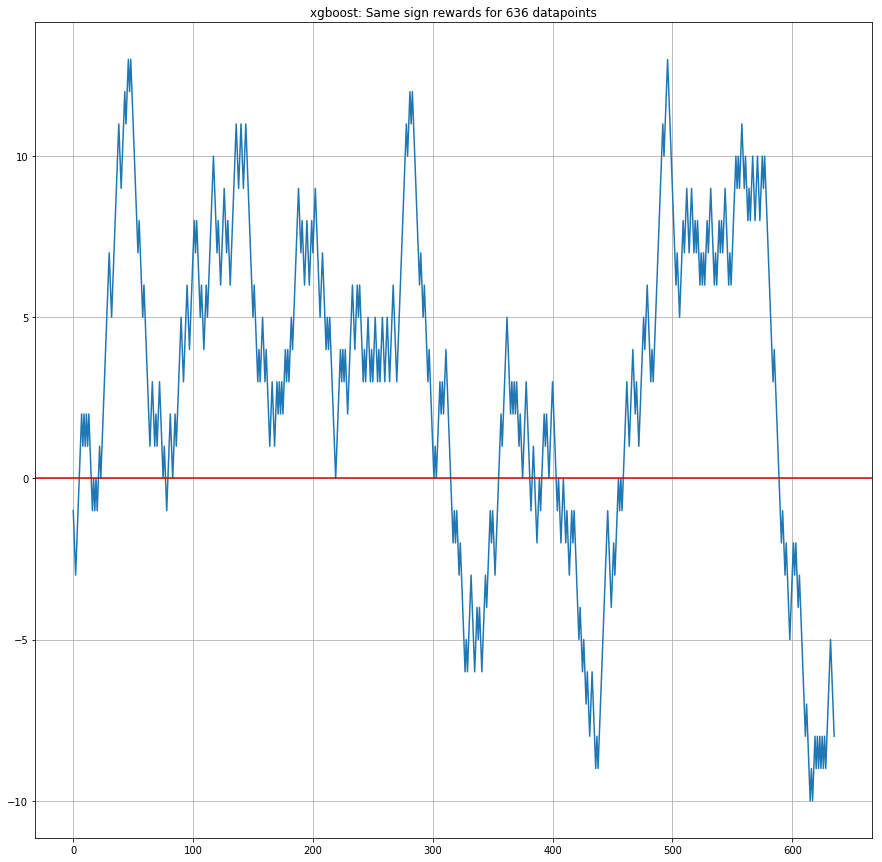

In [53]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("xgboost: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

Text(0.5,1,'xgboost: custom mean loss 0.010802104488701477')

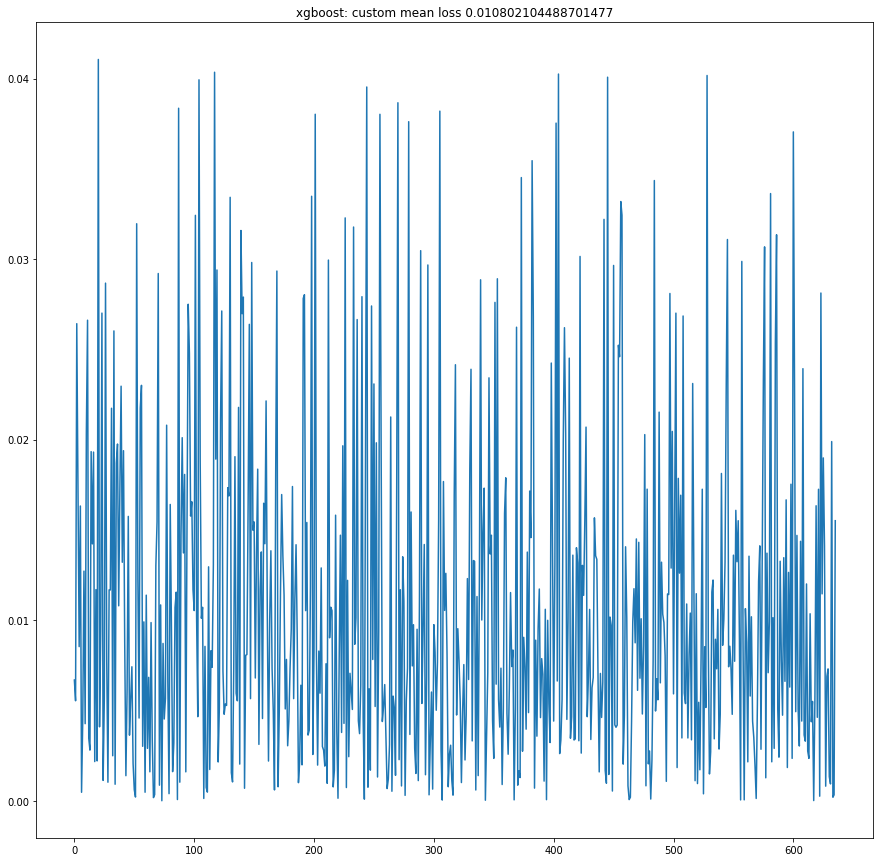

In [102]:
vectfunc = np.vectorize(customLoss,otypes=[np.float],cache=False)
customL = list(vectfunc(actual_and_test[:,0],actual_and_test[:,1]))
plt.rc("figure",figsize=(15,15))
plt.plot(customL)
plt.title("xgboost: custom mean loss " + str(np.mean(customL)))

# Extra Trees regressor

In [54]:

# Fit estimators
model_et  = ExtraTreesRegressor()

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(10, 250, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(10, 110,11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(
    estimator = model_et, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=1, 
    random_state=42, 
    n_jobs = -1)

rf_random.fit(X_train, y_train)

print ("Coefficient of determination on training set: (R^2)",rf_random.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(rf_random, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Coefficient of determination on training set: (R^2) 0.23493468582035007
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Average coefficient of determination using 5-fold crossvalidation: -0.03079010329662335


In [55]:
rf_random.best_params_

{'n_estimators': 140,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

# Fit best params

In [56]:
model_et = ExtraTreesRegressor(**rf_random.best_params_)
model_et.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=10,
          max_features='log2', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=7,
          min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 9 - Weekday (0.078924)
2. feature 1 - Daymonth (0.074754)
3. feature 5 - Month (0.073286)
4. feature 12 - Weakyear (0.071107)
5. feature 11 - MSFT_logReturns (0.067716)
6. feature 6 - SNP_TECH_logReturns (0.064177)
7. feature 10 - NASDAQ_COMP_logReturns (0.061594)
8. feature 4 - VIX_logReturns (0.059817)
9. feature 15 - Volume_Scaled (0.059473)
10. feature 7 - ATR_Scaled (0.059412)
11. feature 14 - TSI_Scaled (0.057893)
12. feature 8 - OBV_Scaled (0.057469)
13. feature 13 - TradingRange_Scaled (0.056839)
14. feature 0 - HighestHigh_Scaled (0.056162)
15. feature 2 - LowestLow_Scaled (0.052880)
16. feature 3 - KFMean_Scaled (0.048499)


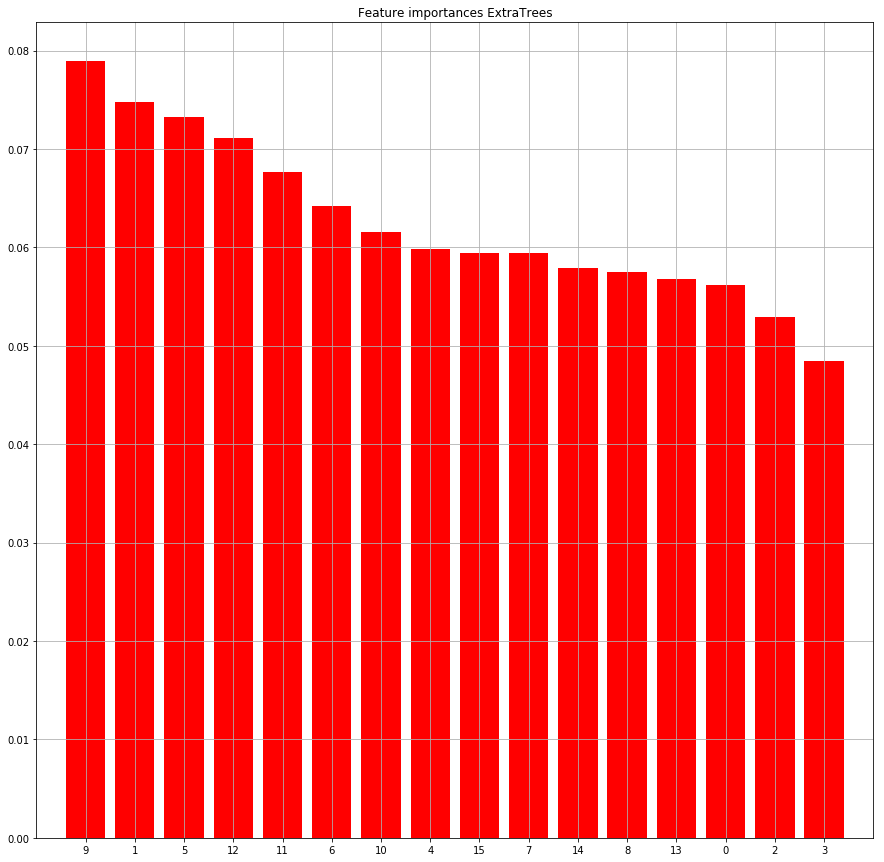

In [57]:
# Show importance of features
importances = model_et.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))
    
    
# Plot the feature importances of the forest
plt.rc("figure",figsize=(15,15))
plt.figure()
plt.title("Feature importances ExtraTrees")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.grid(True)
plt.show()


1. feature 9 - Weekday (0.078924)
2. feature 1 - Daymonth (0.074754)
3. feature 5 - Month (0.073286)
4. feature 12 - Weakyear (0.071107)
5. feature 11 - MSFT_logReturns (0.067716)
6. feature 6 - SNP_TECH_logReturns (0.064177)
7. feature 10 - NASDAQ_COMP_logReturns (0.061594)
8. feature 4 - VIX_logReturns (0.059817)


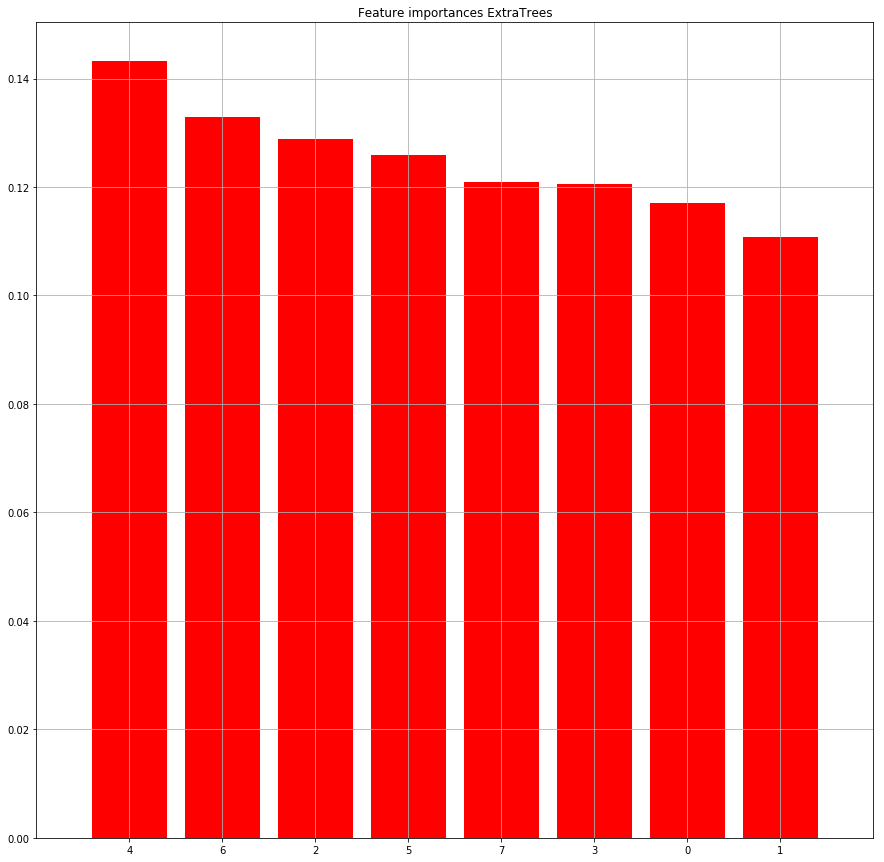

0.01539108712411216

In [58]:
selection = fs.SelectFromModel(model_et, threshold="median", prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = ExtraTreesRegressor()
# Fit with new features
selection_model.fit(select_X_train, y_train)
# Plot new importances
for f in range(select_X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))
    
# Show importance of features
importances = selection_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.rc("figure",figsize=(15,15))
plt.figure()
plt.title("Feature importances ExtraTrees")
plt.bar(range(select_X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(select_X_train.shape[1]), indices)
plt.xlim([-1, select_X_train.shape[1]])
plt.grid(True)
plt.show()


# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
actual_and_test = np.column_stack([y_test, y_pred])
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))
rms

# No feature selection and test

In [103]:
predicted_values = model_et.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

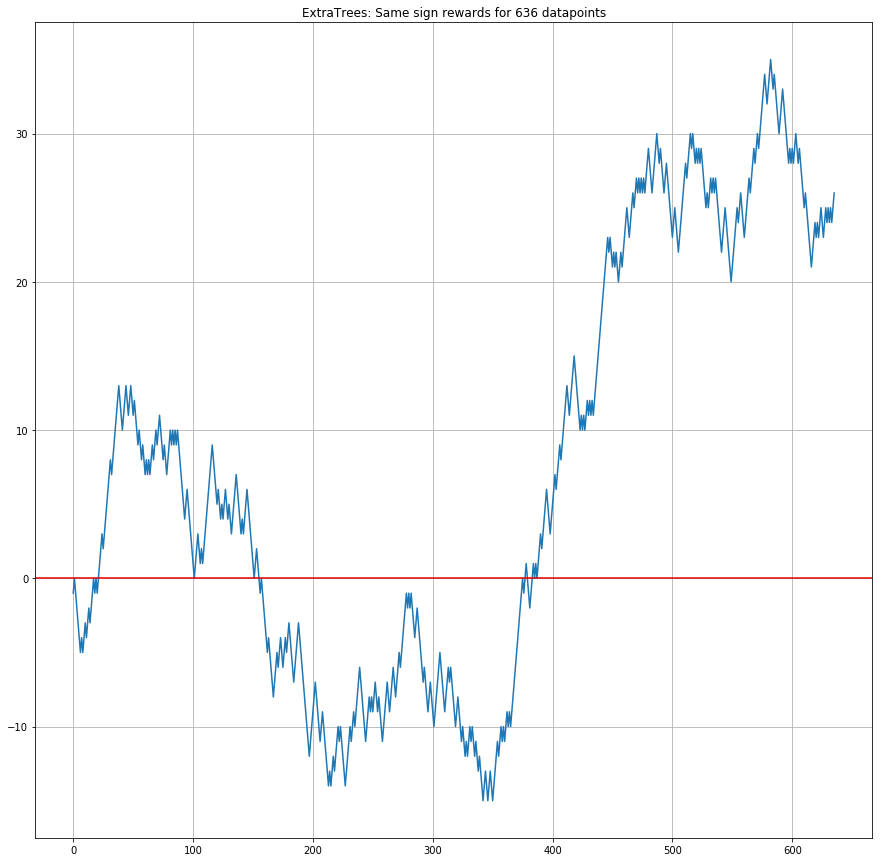

In [104]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("ExtraTrees: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

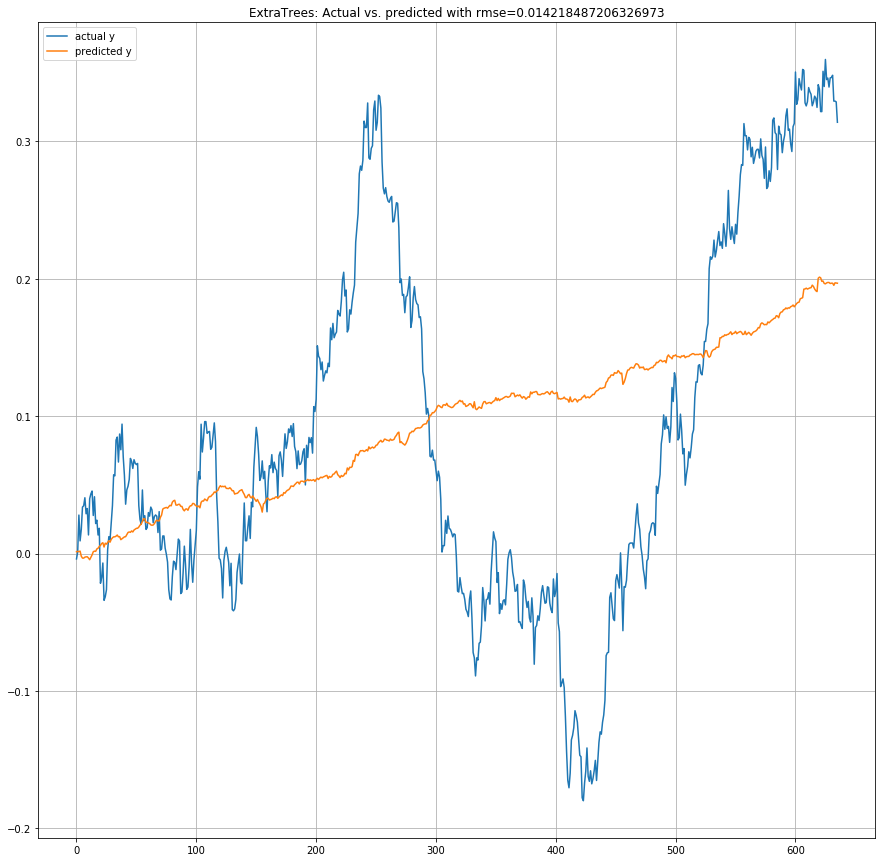

In [105]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("ExtraTrees: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

Text(0.5,1,'xgboost: custom mean loss 0.010806335132498245')

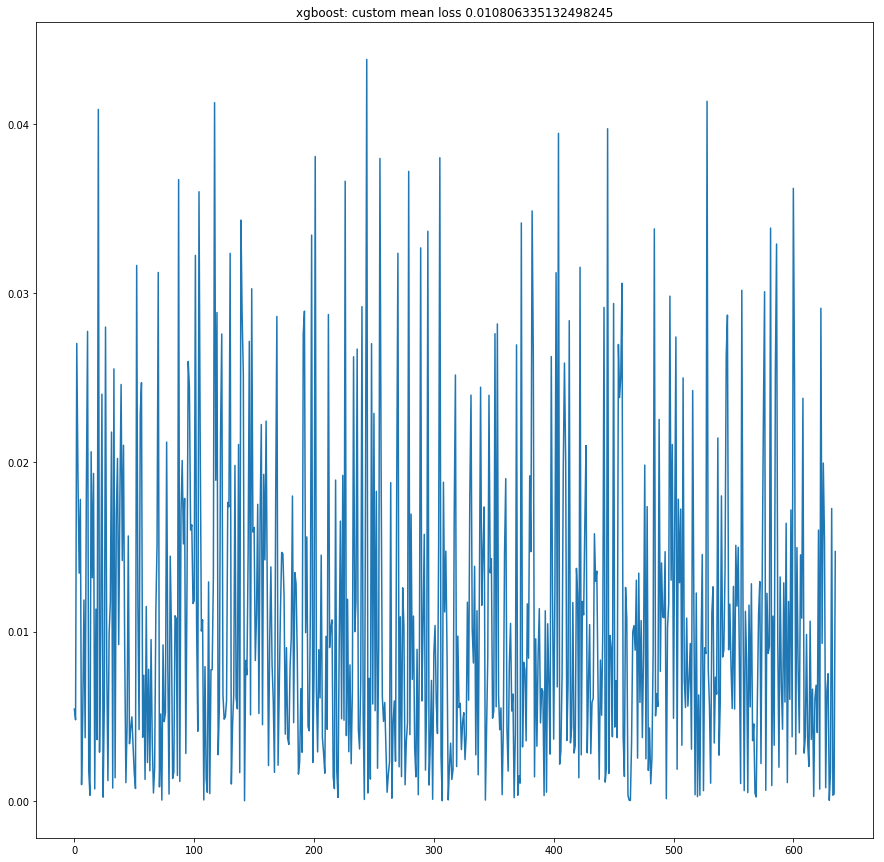

In [106]:
vectfunc = np.vectorize(customLoss,otypes=[np.float],cache=False)
customL = list(vectfunc(actual_and_test[:,0],actual_and_test[:,1]))
plt.rc("figure",figsize=(15,15))
plt.plot(customL)
plt.title("ExtraTrees: custom mean loss " + str(np.mean(customL)))

# Linear regression model

In [111]:
lr = linear_model.LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
predicted_values = lr.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

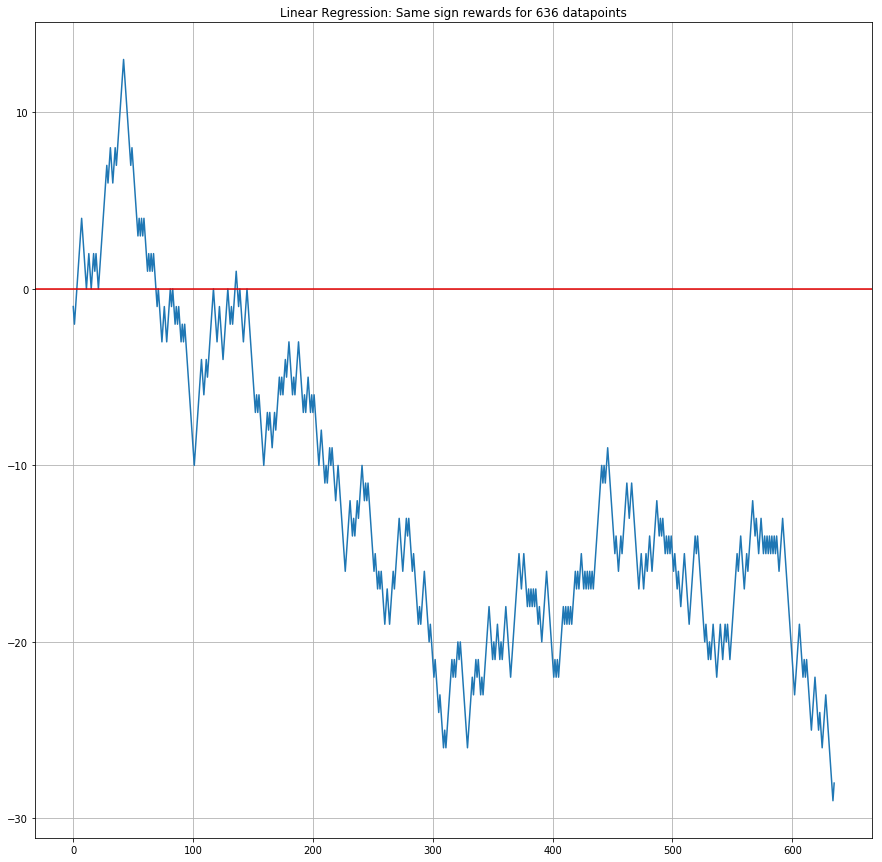

In [112]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("Linear Regression: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

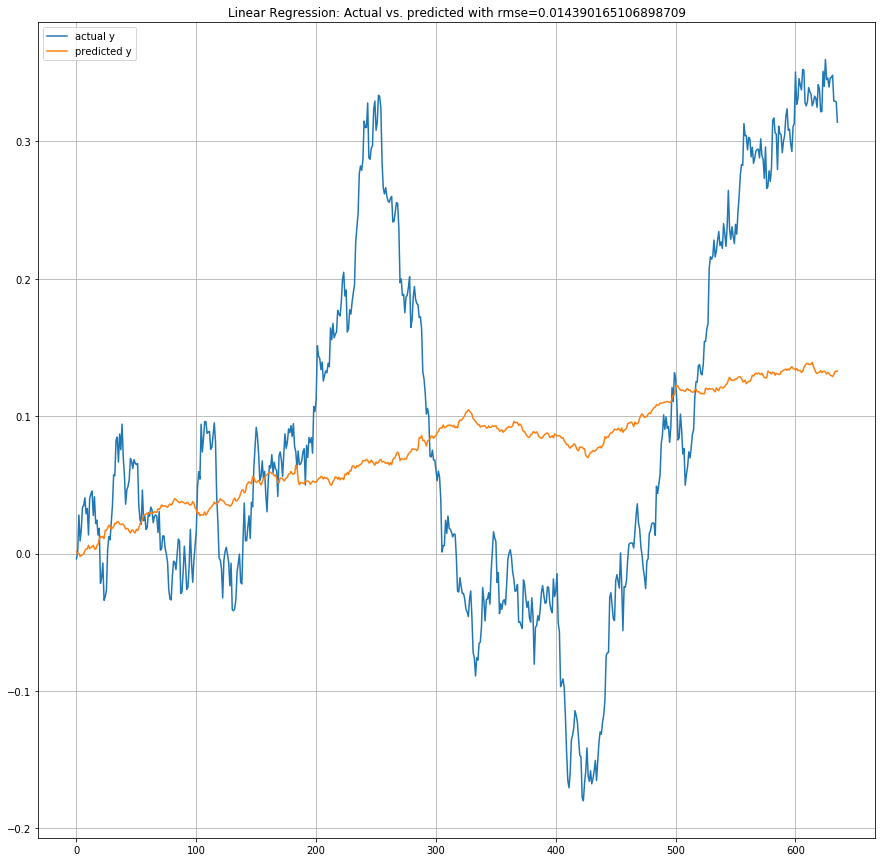

In [113]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("Linear Regression: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

Text(0.5,1,'xgboost: custom mean loss 0.011021957452751458')

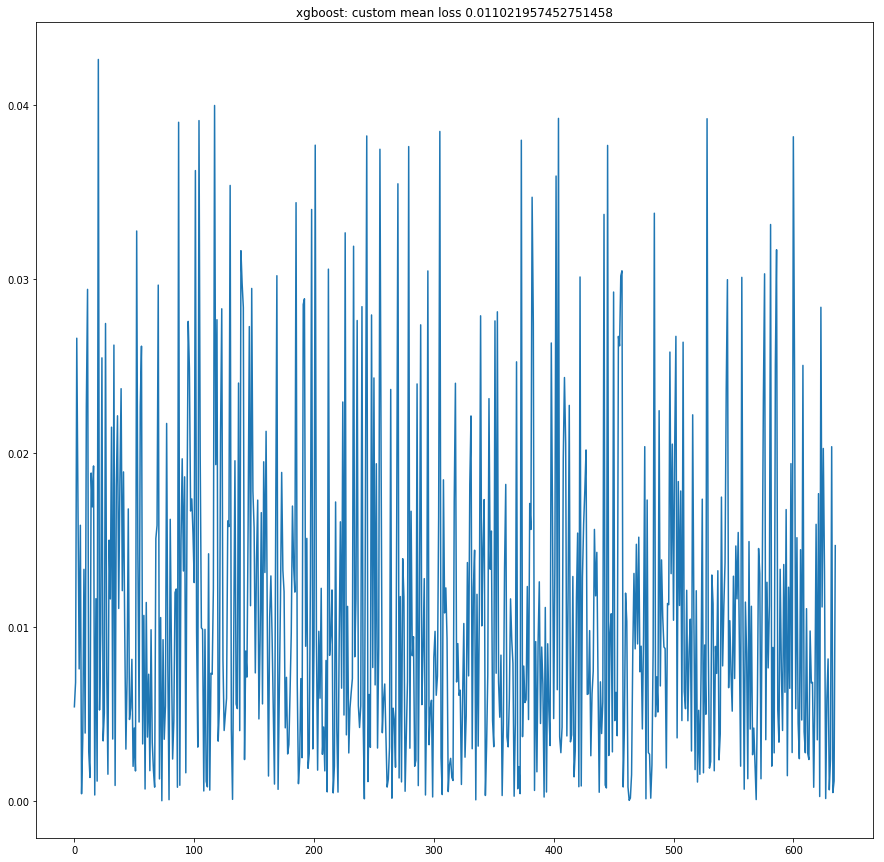

In [114]:
vectfunc = np.vectorize(customLoss,otypes=[np.float],cache=False)
customL = list(vectfunc(actual_and_test[:,0],actual_and_test[:,1]))
plt.rc("figure",figsize=(15,15))
plt.plot(customL)
plt.title("Linear regression: custom mean loss " + str(np.mean(customL)))

In [107]:
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
predicted_values = ridge.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

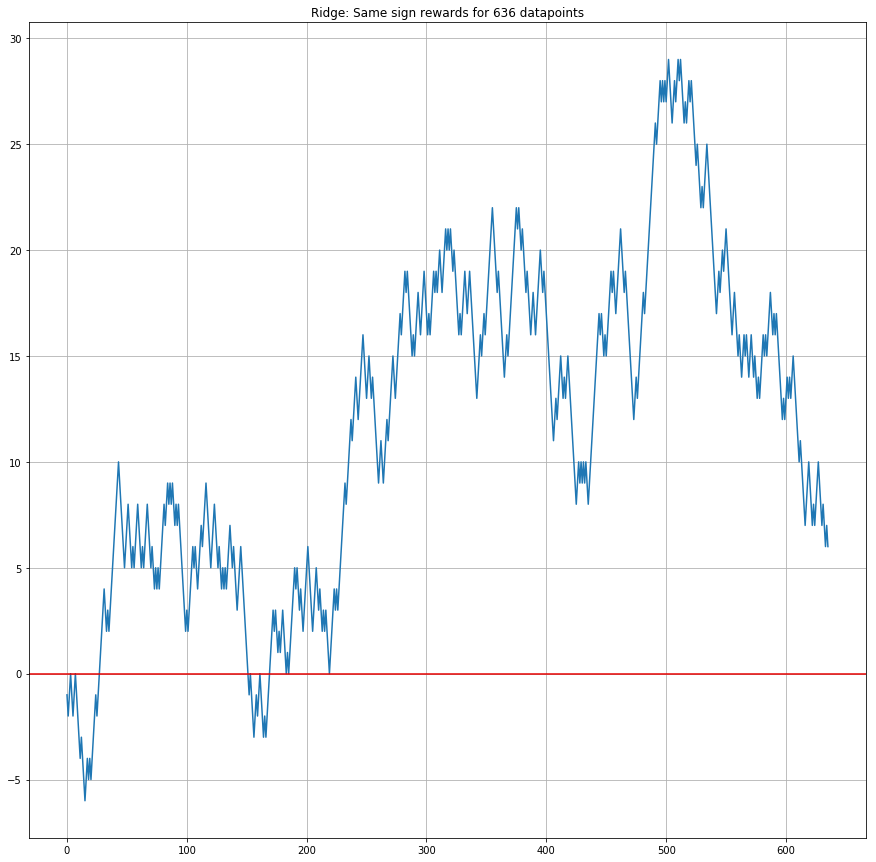

In [108]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("Ridge: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

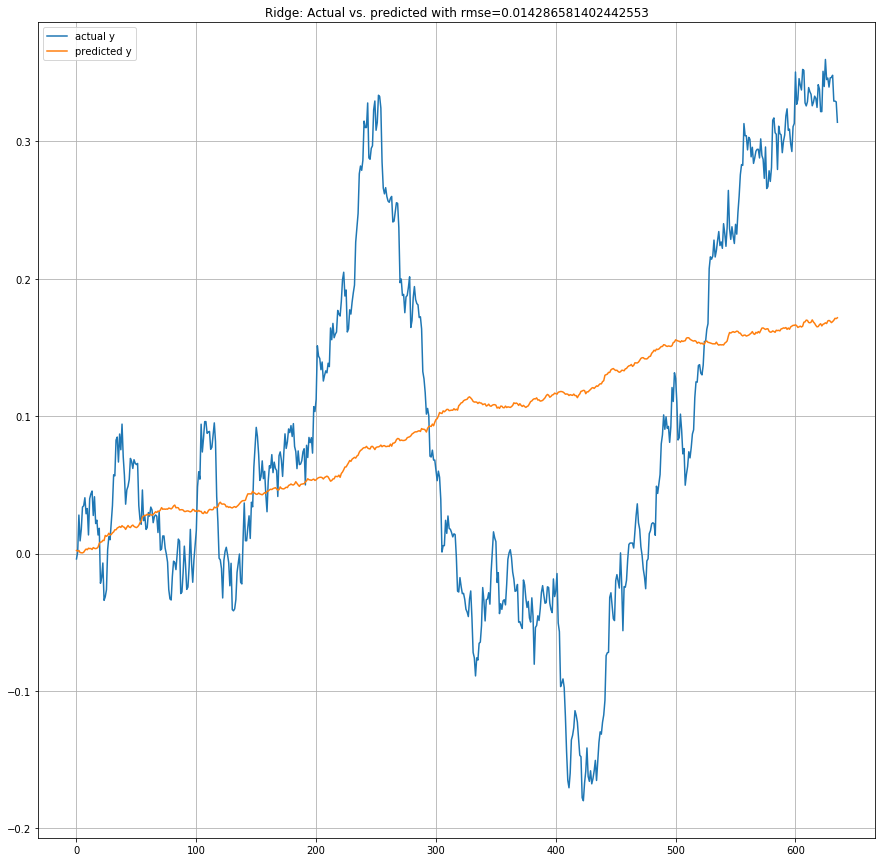

In [109]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("Ridge: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

Text(0.5,1,'xgboost: custom mean loss 0.010802104488701477')

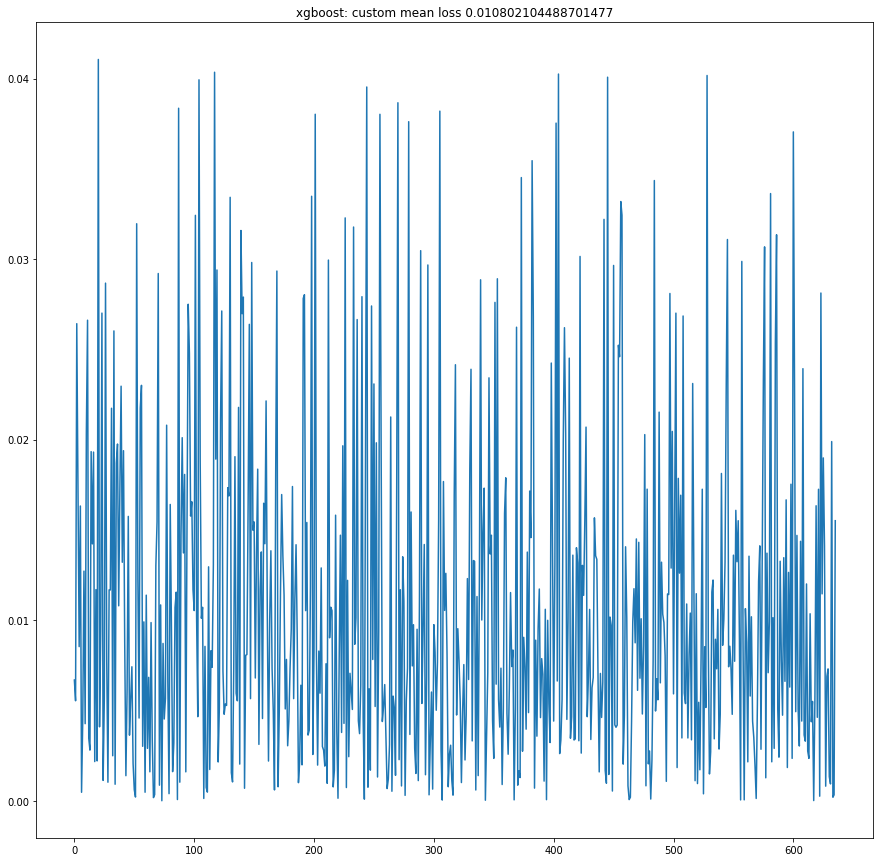

In [110]:
vectfunc = np.vectorize(customLoss,otypes=[np.float],cache=False)
customL = list(vectfunc(actual_and_test[:,0],actual_and_test[:,1]))
plt.rc("figure",figsize=(15,15))
plt.plot(customL)
plt.title("ridge: custom mean loss " + str(np.mean(customL)))

In [124]:
rms_min = 1
w1=w2=w3=w4 = 0
for i in range(1000):
    x1 = np.random.choice([x/10 for x in range(1, 10, 1)])
    x2 = np.random.choice([x/10 for x in range(1, 10, 1)])
    x3 = np.random.choice([x/10 for x in range(1, 10, 1)])
    x4 = np.random.choice([x/10 for x in range(1, 10, 1)])
    predict_overall = x1*ridge.predict(X_test) 
    +  x2*model_et.predict(X_test) 
    + x3*xgb.predict(X_test) 
    + x4*lr.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, predict_overall))
    if rms < rms_min:
        rms_min = rms
        w1 = x1
        w2 = x2
        w3 = x3
        w4 = x4
        print("best rmse so far:" +str(rms))
print("best rmse:" +str(rms_min) + ", w1 (ridge): " + str(w1) + ", w2 (extratrees): " 
      + str(w2) + ", w3 (xgboost): " + str(w3) + ", w4 (linearreg): " + str(w4) )
# best 0.01407537306047969
weight = [w1,w2,w3,w4]
# ridge, extratrees, xgb, linear reg
weight

best rmse so far:0.014282904120959464
best rmse so far:0.014282010517912822
best rmse:0.014282010517912822, w1 (ridge): 0.6, w2 (extratrees): 0.1, w3 (xgboost): 0.7, w4 (linearreg): 0.4


In [240]:
from sklearn.externals import joblib

s = joblib.dump(ridge, 'ridge.pkl')
s = joblib.dump(model_et, 'extratrees.pkl')
s = joblib.dump(xgb, 'xgb.pkl')
s = joblib.dump(lr, 'ridge.pkl')

In [300]:
predict_overall = w1*ridge.predict(X_test) 
+  w2*model_et.predict(X_test) 
+ w3*xgb.predict(X_test) 
+ w4*lr.predict(X_test)

backtest = X_test.copy()
backtest['pred'] = predict_overall
backtest = pd.merge(backtest, INTC, left_index=True, right_index=True)
backtest.sort_index(inplace=True)

In [301]:
backtest.head(2)

Weekday  Daymonth  Month  Weakyear  MSFT_logReturns  \
Date                                                              
2010-01-12        1        12      1         2        -0.006629   
2010-01-13        2        13      1         2         0.009269   

            SNP_TECH_logReturns  NASDAQ_COMP_logReturns  VIX_logReturns  \
Date                                                                      
2010-01-12            -0.010953               -0.013102        0.039111   
2010-01-13             0.009645                0.011150       -0.022162   

            Volume_Scaled  ATR_Scaled  TSI_Scaled  OBV_Scaled  \
Date                                                            
2010-01-12       0.351545    0.214679   -0.295785   -0.351545   
2010-01-13       0.359024    0.233720   -0.185215    0.359024   

            TradingRange_Scaled  HighestHigh_Scaled  LowestLow_Scaled  \
Date                                                                    
2010-01-12             0.109474            0.367188            0.3804   
2010-01-13             0.134737            0.367188            0.3804   

            KFMean_Scaled      pred       Open   High        Low      Close  \
Date                                                                          
2010-01-12       0.355946 -0.000961  20.870001  20.90  20.379999  20.610001   
2010-01-13       0.355946 -0.000441  20.719999  21.08  20.440001  20.959999   

            Adj Close    Volume  
Date                             
2010-01-12  15.605186  69958400  
2010-01-13  15.870193  71446700

In [303]:
pos = False
buyPrice = 0
sellPrice = 0
ret = []
for i in range(len(backtest)):
    pred = backtest['pred'][i] 
    if not pos:
        if pred >= 0:
            pos = True
            buyPrice = backtest['Close'][i]
    else:
        if pred < 0:
            pos = False
            sellPrice = backtest['Close'][i]
            ret.append(buyPrice-sellPrice)

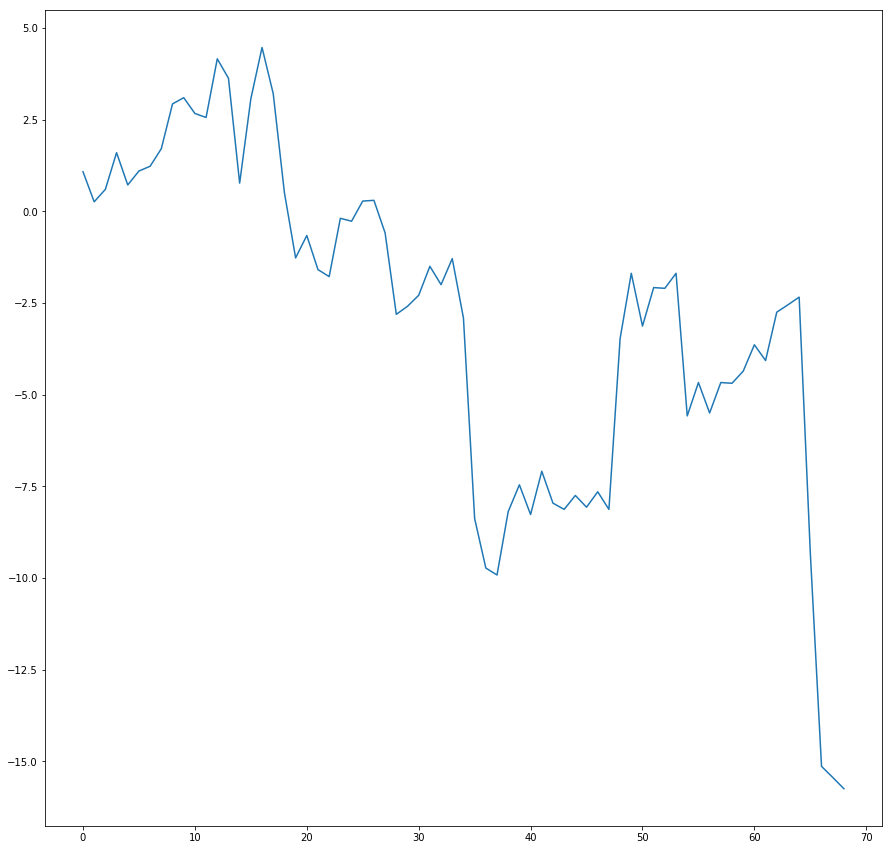

In [307]:
plt.plot(np.cumsum(ret))